In [1]:
%autosave 600
import numpy as np
import pandas as pd
import scipy.stats as st
from datetime import datetime
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import time
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

import optuna
from optuna.samplers import TPESampler

import shap

Autosaving every 600 seconds


In [2]:
class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns 
        
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [3]:
def plot_AUC(y_real: np.ndarray, predictions: np.ndarray, model_name: str=None) -> None:
    AUC_PR_mean = []
    AUC_ROC_mean = []
    for y_r, y_p in zip(y_real, predictions):
        
        positive = y_r.sum()
        
        plt.figure(figsize=(16, 8))

        plt.subplot(121)
        precision, recall, thresholds = precision_recall_curve(y_r, y_p)
        AUC_PR = round(auc(recall, precision), 5)
        plt.plot(recall, precision, lw = 1.5)
        plt.axhline(positive/y_r.shape[0], 0, 1, linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(label='AUC_PR={}'.format(AUC_PR))
        plt.legend([model_name, 'Random Classifier'])
        plt.grid()

        
        plt.subplot(122)
        fpr, tpr, thresholds = roc_curve(y_r, y_p)
        AUC_ROC = round(auc(fpr, tpr), 5)
        Gini = round(2*AUC_ROC - 1, 5)
        plt.plot(fpr, tpr, lw=1.5)
        plt.plot([0, 1], [0, 1], linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(label='AUC_ROC={} (Gini={})'.format(AUC_ROC, Gini))
        plt.legend([model_name, 'Random Classifier'])

        plt.grid()
        plt.tight_layout()
        plt.show()
        
        AUC_PR_mean.append(AUC_PR)
        AUC_ROC_mean.append(AUC_ROC)
        
    if len(AUC_PR_mean) != 1:
        print('MEAN AUC-PR - {}'.format(round(np.array(AUC_PR_mean).mean(), 5)))
        print('MEAN AUC-ROC - {}'.format(round(np.array(AUC_ROC_mean).mean(), 5)))
        

In [4]:
def show_pred_dist(y_true: np.ndarray, y_pred: np.ndarray, threshold: float=0.5) -> None:
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot()
    sns.distplot(y_pred[y_true == 1], ax=ax, label='true')
    sns.distplot(y_pred[y_true == 0], ax=ax, label='false')
#     ax.axvline(threshold, ls='--', label='threshold')
    plt.title('LogReg')
    plt.legend()
    plt.show()

# 3. c. d. Обработка данных для логистической регрессии

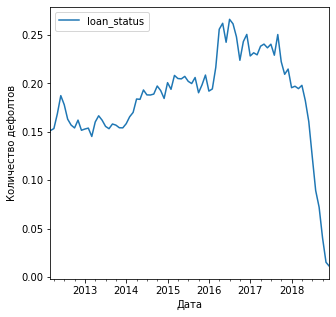

In [5]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state']
coun = df.groupby(['issue_d']).count()[['loan_status']]
summ = df.groupby(['issue_d']).sum()[['loan_status']]
(summ / coun).plot(figsize=(5,5))
plt.xlabel('Дата')
plt.ylabel('Количество дефолтов')
plt.show()

In [6]:
df = df[df.issue_d < np.datetime64('2018-06-01')].reset_index().drop('index', axis=1)
df = MultiColumnLabelEncoder(columns = cat).fit_transform(df)

#### OHE

In [7]:
OHE_cat = ['home_ownership', 'verification_status', 'purpose', 'addr_state']   

enc = OneHotEncoder(drop='first', sparse=False)
for OHE in tqdm(OHE_cat):
    col = enc.fit_transform(df[OHE].values.reshape(-1, 1))
    hot_col = pd.DataFrame(col, columns=[OHE + '_' + str(i) for i in range(col.shape[1])])
    df = pd.concat([df, hot_col], axis=1)

100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


#### 2. Выделим обучающую, валидационную и тестовую часть

In [8]:
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
train = df[df.issue_d < np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
X_test_lr, y_test_lr = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

#### Скалирование переменных

In [9]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_test_lr.columns)

X_test_lr = scaler.transform(X_test_lr)
X_test_lr = pd.DataFrame(X_test_lr, columns=X.columns)

# 2. Разбейте выборку на несколько частей для построения модели и анализа качества

In [10]:
train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

In [11]:
X_train_lr, X_val_lr = X.loc[train_inx], X.loc[val_inx]
X_global_train_lr = pd.concat([X_train_lr, X_val_lr], ignore_index=True)
y_train_lr, y_val_lr = y.loc[train_inx], y.loc[val_inx]
y_global_train_lr = pd.concat([y_train_lr, y_val_lr], ignore_index=True)

## Запишем результаты

In [12]:
pos = y_global_train_lr.sum() / y_global_train_lr.shape[0] 
neg = (y_global_train_lr.shape[0] - y_global_train_lr.sum()) / y_global_train_lr.shape[0]

results = pd.DataFrame({'random_classifier': [0.5, 0.5, pos, 0.5, 0, 0.5, neg**2+pos**2]})

results.index = ['Precision', 'Recall', 'AUC-PR', 'AUC-ROC', 'Gini', 'F1_score', 'Accuracy']

### Постройте интерпретируемый скоринг (Логистическая регрессия)

In [13]:
def compute_metrics(y_test: pd.Series, 
                    y_pred_binary: np.ndarray, 
                    y_pred_prob: np.ndarray) -> list:
    
    precision = precision_score(y_test, y_pred_binary, average='macro')
    recall = recall_score(y_test, y_pred_binary, average='macro')
    AUC_PR = average_precision_score(y_test, y_pred_prob)
    AUC_ROC = roc_auc_score(y_test, y_pred_prob)
    Gini = 2*AUC_ROC - 1
    f1 = f1_score(y_test, y_pred_binary, average='macro')
    accuracy = accuracy_score(y_test, y_pred_binary)
    
    return [precision, recall, AUC_PR, AUC_ROC, Gini, f1, accuracy]

In [14]:
def get_results(model, data_summary: pd.DataFrame,
                train_x: pd.DataFrame, train_y: pd.Series, 
                test_x: pd.DataFrame, test_y: pd.Series, 
                cat_feat: list=None, column_name: str=None, 
                name_model: str=None, mode: str='logreg') -> pd.DataFrame:
    
    assert mode in ['logreg', 'gbm'], \
    "Mode value should be 'logreg' or 'gbm'! Yours value = '{}'".format(mode)
    
    if mode == 'gbm':
        model.fit(train_x, train_y, feature_name=train_x.columns.tolist(), categorical_feature=cat_feat)
    else:
        model.fit(train_x, train_y)
    pred_prob = model.predict_proba(test_x)[:,1]
    pred_binary = np.where((pred_prob >= 0.5), 1, 0)
    
    data_summary[column_name] = compute_metrics(test_y, pred_binary, pred_prob)
    
    print(classification_report(test_y, pred_binary))
    plot_AUC([test_y], [pred_prob], name_model)
    
    return data_summary, pred_prob

In [15]:
LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)

              precision    recall  f1-score   support

           0       0.85      0.70      0.77    155310
           1       0.36      0.59      0.45     45127

    accuracy                           0.67    200437
   macro avg       0.61      0.64      0.61    200437
weighted avg       0.74      0.67      0.70    200437



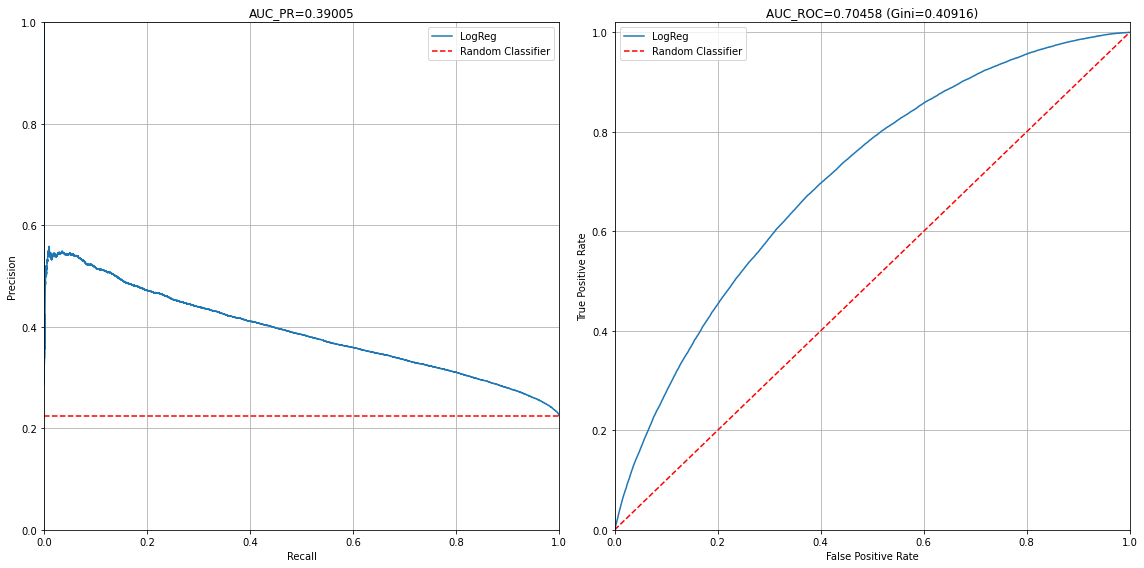

In [31]:
results, y_preds_lr = get_results(model=LR, data_summary=results, 
                                  train_x = X_global_train_lr, 
                                  train_y = y_global_train_lr, 
                                  test_x = X_test_lr, 
                                  test_y = y_test_lr, 
                                  cat_feat = None, 
                                  column_name = 'Log_Reg', 
                                  name_model = 'LogReg',  
                                  mode = 'logreg')

In [17]:
results

,random_classifier,Log_Reg
Precision,0.500000,0.607630
Recall,0.500000,0.643622
AUC-PR,0.199262,0.390078
AUC-ROC,0.500000,0.704576
Gini,0.000000,0.409152
F1_score,0.500000,0.607647
Accuracy,0.680886,0.672331


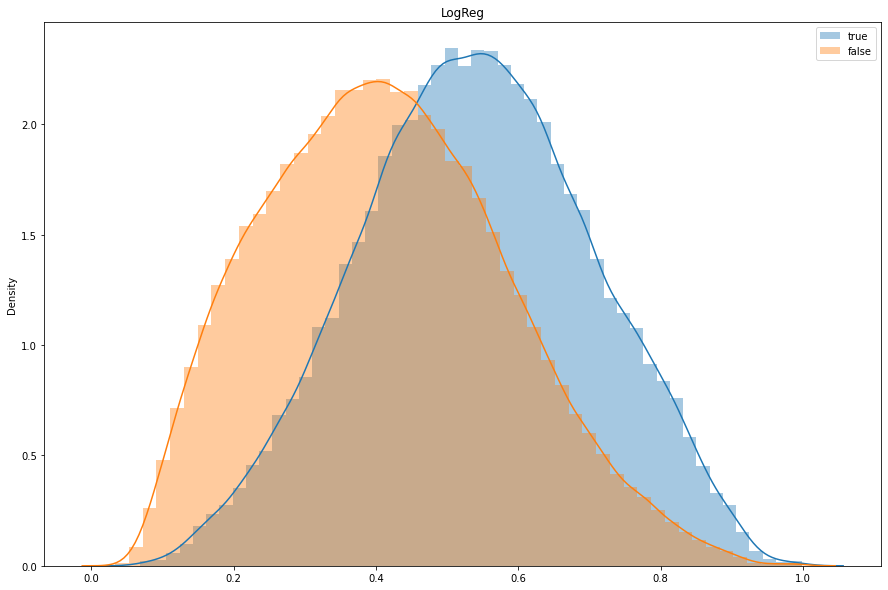

In [18]:
show_pred_dist(y_test_lr, y_preds_lr)

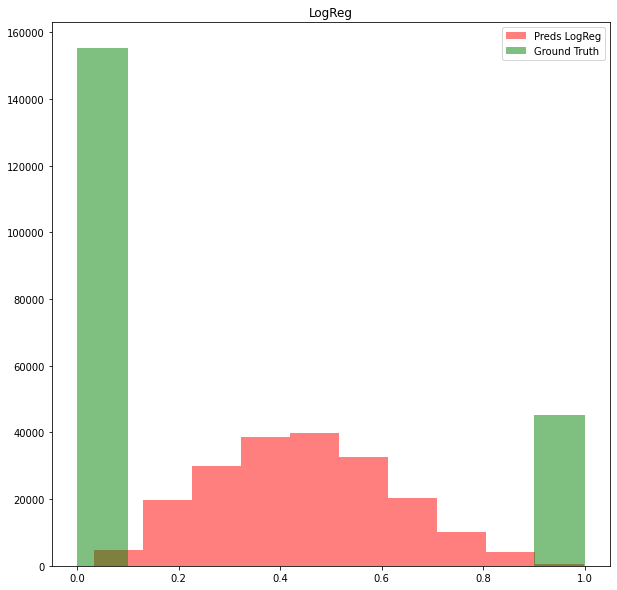

In [19]:
plt.figure(figsize=(10,10))
plt.hist(y_preds_lr, bins=10, alpha=0.5, color='r', label='Preds LogReg')
plt.hist(y_test_lr, bins= 10, alpha=0.5, color='g', label='Ground Truth')
plt.legend()
plt.title('LogReg')
plt.show()

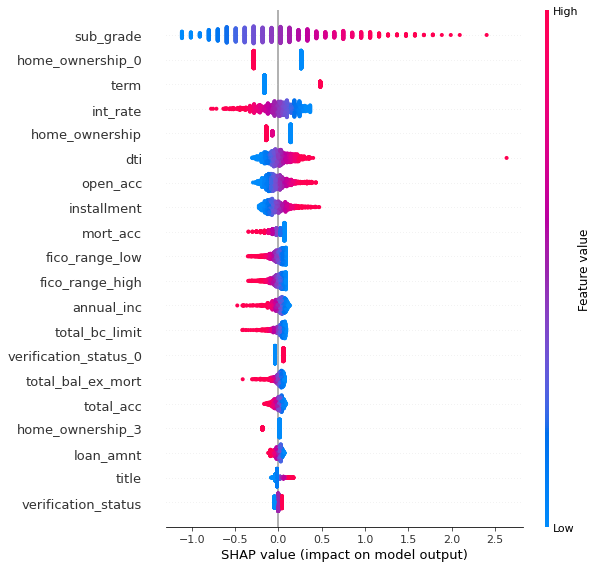

In [20]:
sample = X_global_train_lr.sample(1000)
explainer = shap.Explainer(LR, sample)
shap_values = explainer(sample)
shap.summary_plot(shap_values, sample)

# 4. Постройте любую модель машинного обучения на этих же данных с качеством выше (LightGBM)

In [16]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])
df = df[df.issue_d < np.datetime64('2018-06-01')].reset_index().drop('index', axis=1)
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state']

In [17]:
df = MultiColumnLabelEncoder(columns = cat).fit_transform(df)

In [18]:
# Сплитуем выборку
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
train = df[df.issue_d < np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

X_train, X_val = X.loc[train_inx], X.loc[val_inx]
X_global_train = pd.concat([X_train, X_val], ignore_index=True)
y_train, y_val = y.loc[train_inx], y.loc[val_inx]
y_global_train = pd.concat([y_train, y_val], ignore_index=True)

In [19]:
category = ['term', 'grade', 'sub_grade', 'home_ownership', 
            'verification_status', 'purpose', 'zip_code', 'addr_state']

In [20]:
param = {'n_estimators': 1000,
         'learning_rate': 0.012,
         'num_leaves': 89,
         'min_child_samples': 29, 
         'objective': 'binary', 
         'max_depth': 21,  
         "boosting_type": "gbdt", 
         "metric": 'auc', 
         'reg_alpha': 0.22, 
         'reg_lambda': 0.2, 
         'is_unbalance': True,
         'importance_type': 'gain',
         'verbose': -1}

gbm = LGBMClassifier(**param)

              precision    recall  f1-score   support

           0       0.87      0.64      0.74    155310
           1       0.35      0.67      0.46     45127

    accuracy                           0.65    200437
   macro avg       0.61      0.66      0.60    200437
weighted avg       0.75      0.65      0.68    200437



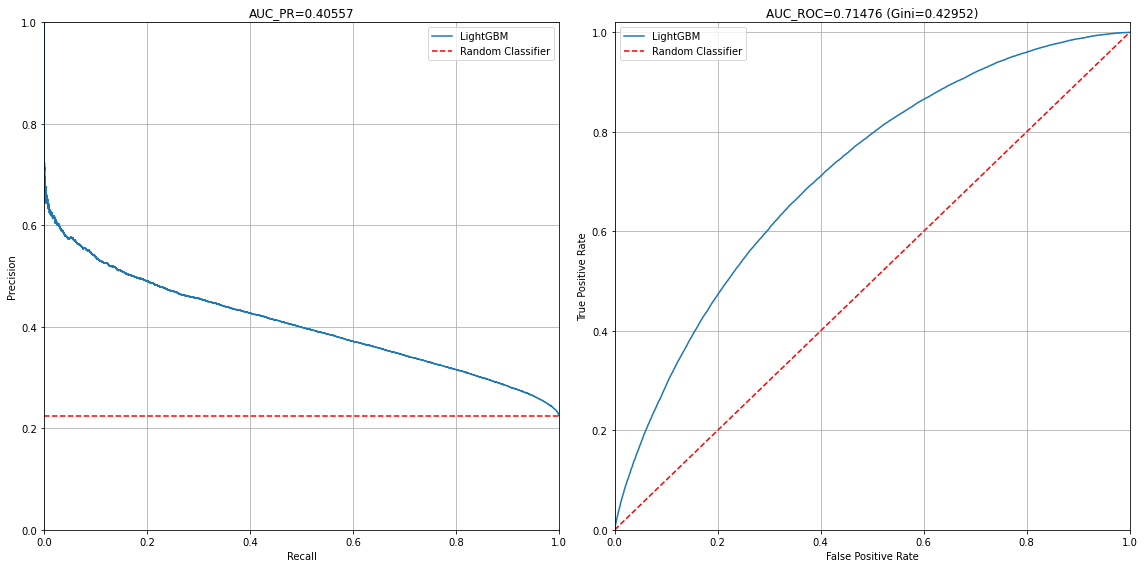

In [32]:
results, y_preds_gbm = get_results(gbm, results, 
                                   X_global_train, y_global_train, 
                                   X_test, y_test, 
                                   category, 'LightGBM', 'LightGBM', 'gbm')

In [27]:
results

,random_classifier,Log_Reg,LightGBM
Precision,0.500000,0.607630,0.611260
Recall,0.500000,0.643622,0.655983
AUC-PR,0.199262,0.390078,0.405594
AUC-ROC,0.500000,0.704576,0.714764
Gini,0.000000,0.409152,0.429528
F1_score,0.500000,0.607647,0.600850
Accuracy,0.680886,0.672331,0.649326


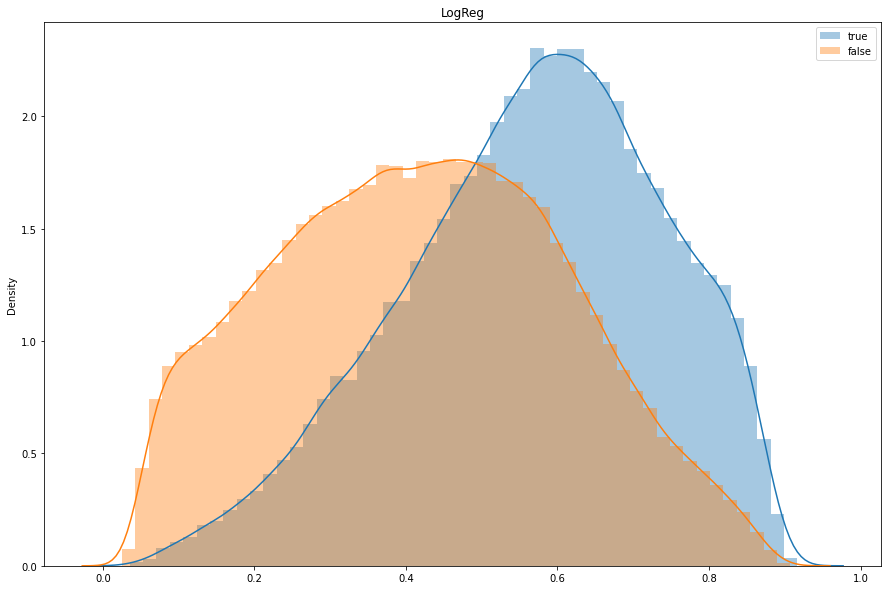

In [28]:
show_pred_dist(y_test, y_preds_gbm, 'LightGBM')

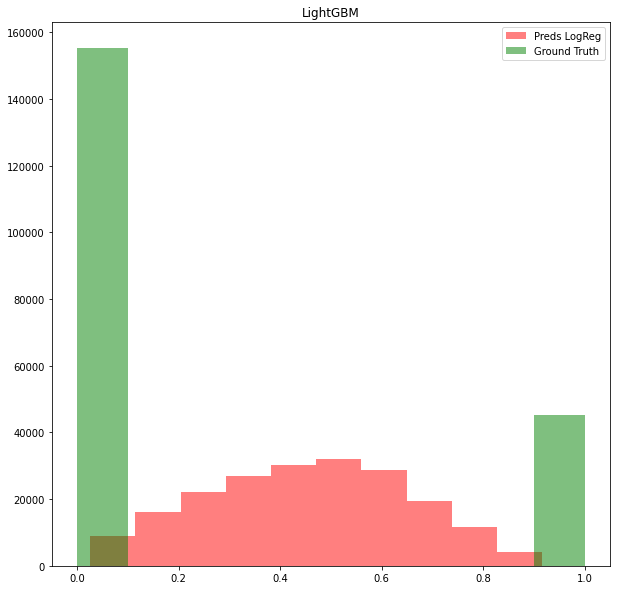

In [29]:
plt.figure(figsize=(10,10))
plt.hist(y_preds_gbm, bins=10, alpha=0.5, color='r', label='Preds LogReg')
plt.hist(y_test, bins= 10, alpha=0.5, color='g', label='Ground Truth')
plt.legend()
plt.title('LightGBM')
plt.show()

# Важность признаков

In [30]:
feature = pd.DataFrame({
    'feature_name': X_train.columns,
    'importance': gbm.feature_importances_
})

feature_sorted = feature.sort_values(by='importance', ascending=False)

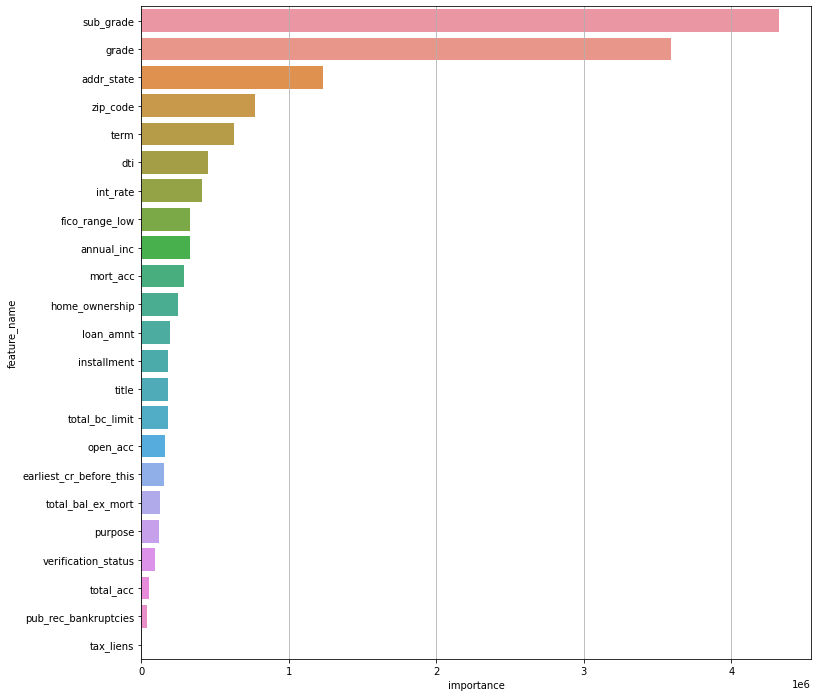

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.grid()
sns.barplot(x="importance", y="feature_name", data=feature_sorted[feature_sorted.importance != 0])

plt.show()

# Тесты 1. Значимость факторов

In [21]:
def one_feat_gini(x_train: pd.DataFrame, x_val: pd.DataFrame, 
                  y_train: pd.Series, y_val: pd.Series, 
                  factors: list, model_type: str="logreg") -> pd.DataFrame:
    
    gini_scores = []
    factor_intervals = {}
    df_intervals = pd.DataFrame()

    for factor in tqdm(factors):
        
        if model_type == "logreg":
            mod = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21, n_jobs=7)
            mod.fit(x_train[factor].to_numpy().reshape(-1, 1), y_train)
        elif model_type == "gbm":
            mod = LGBMClassifier(**param)
            mod.fit(x_train[factor].to_numpy().reshape(-1, 1), y_train)
            
        y_pred = mod.predict_proba(x_val[factor].to_numpy().reshape(-1, 1))[:, 1]
        gini_scores.append(2 * roc_auc_score(y_val, y_pred) - 1)
        bs_gini = []
        np.random.seed(0)
        
        for _ in np.arange(200):
            
            bs = np.random.randint(0, y_val.shape[0], y_val.shape[0])
            auc_bs = roc_auc_score(y_val[bs], y_pred[bs])
            bs_gini.append(2*auc_bs-1)
        
        factor_intervals[factor] = "{:0.3f}".format(np.quantile(bs_gini, 0.025)),  \
                                   "{:0.3f}".format(np.quantile(bs_gini, 1-0.025)), \
                                   "{:0.3f}".format(np.quantile(bs_gini, 0.005)),    \
                                   "{:0.3f}".format(np.quantile(bs_gini, 1-0.005))
        lb95, ub95, lb99, ub99 = factor_intervals[factor]
        df_intervals.loc[factor, "95% conf.interval"] = f"[{lb95}; {ub95}]"
        df_intervals.loc[factor, "99% conf.interval"] = f"[{lb99}; {ub99}]" 

    fig = plt.figure(figsize=(20,10))
    plt.bar(x=[j for (i,j) in sorted(zip(gini_scores, factors), reverse=True)],
            height=[i for (i,j) in sorted(zip(gini_scores, factors), reverse=True)],
            color="lightgreen")
    
    if model_type == "logreg":
        plt.title("Значимость факторов\nLogistic Regression", fontsize=18)
        plt.xticks(rotation=90)
    elif model_type == "gbm":
        plt.title("Значимость факторов\nBoosting", fontsize=18)
        plt.xticks(rotation=90)
    
    plt.xlabel("Факторы", fontsize=18)
    plt.ylabel("Индивидуальное значение Gini", fontsize=18)

    plt.show()
        
    return df_intervals

In [ ]:
intervals_lr = one_feat_gini(x_train = X_train_lr.iloc[:30000],
                             x_val = X_val_lr.reset_index().drop(columns='index').iloc[:30000],
                             y_train = y_train_lr.iloc[:30000],
                             y_val = y_val_lr.reset_index().loan_status.iloc[:30000],
                             factors = X_train_lr.columns,
                             model_type="logreg")

  6%|▋         | 6/93 [00:18<04:23,  3.03s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-993160e1eb8b>", line 1, in <module>
    intervals_lr = one_feat_gini(x_train = X_train_lr.iloc[:30000],
  File "<ipython-input-32-351f04e6d26f>", line 26, in one_feat_gini
    auc_bs = roc_auc_score(y_val[bs], y_pred[bs])
  File "E:\Anaconda\lib\site-packages\pandas\core\series.py", line 877, in __getitem__
    return self._get_with(key)
  File "E:\Anaconda\lib\site-packages\pandas\core\series.py", line 912, in _get_with
    return self.loc[key]
  File "E:\Anaconda\lib\site-packages\pandas\core\indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "E:\Anaconda\lib\site-packages\pandas\core\indexing.py", line 1113, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "E:\Anaconda\lib\site-packages\pandas\core\i

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-993160e1eb8b>", line 1, in <module>
    intervals_lr = one_feat_gini(x_train = X_train_lr.iloc[:30000],
  File "<ipython-input-32-351f04e6d26f>", line 26, in one_feat_gini
    auc_bs = roc_auc_score(y_val[bs], y_pred[bs])
  File "E:\Anaconda\lib\site-packages\pandas\core\series.py", line 877, in __getitem__
    return self._get_with(key)
  File "E:\Anaconda\lib\site-packages\pandas\core\series.py", line 912, in _get_with
    return self.loc[key]
  File "E:\Anaconda\lib\site-packages\pandas\core\indexing.py", line 895, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "E:\Anaconda\lib\site-packages\pandas\core\indexing.py", line 1113, in _getitem_axis
    return self._getitem_iterable(key, axis=axis)
  File "E:\Anaconda\lib\site-packages\pandas\core\i

In [33]:
intervals_lr

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 694
Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-bdb688cd6ba2>", line 1, in <module>
    intervals_lr
NameError: name 'intervals_lr' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File

TypeError: object of type 'NoneType' has no len()

In [ ]:
interval_gbm = one_feat_gini(x_train = X_train.iloc[:30000], 
                             x_val = X_val.reset_index().drop(columns='index').iloc[:30000], 
                             y_train = y_train.iloc[:30000], 
                             y_val = y_val.reset_index().loan_status.iloc[:30000], 
                             factors = X_train.columns, 
                             model_type="gbm")

In [ ]:
interval_gbm

# 2. Инкрементарное влияние

In [37]:
def gini_select(x_train: pd.DataFrame, x_val: pd.DataFrame, 
                y_train: pd.Series, y_val: pd.Series, 
                factors: list, model_type: str="logreg") -> None:
    
    gini_increm_0 = []
    gini_increm_1 = []
    factor_intervals = {}
    df_intervals = pd.DataFrame()
    best_factors = []
    prev_gini_1 = 0

    while len(best_factors) < len(factors):
        prev_gini_0 = prev_gini_1
        best_ginis = {}
        
        for factor in tqdm(factors):  
            if factor not in best_factors:
                best_factors.append(factor)
                
                if model_type == "logreg":
                    mod = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21, n_jobs=7)
                else:
                    mod = LGBMClassifier(**param)   
                
                if len(best_factors) == 1:
                    mod.fit(x_train[best_factors].to_numpy().reshape(-1, 1), y_train)
                    y_pred = mod.predict_proba(x_val[best_factors].to_numpy().reshape(-1,1))[:, 1]
                else:
                    mod.fit(x_train[best_factors], y_train)
                    y_pred = mod.predict_proba(x_val[best_factors])[:, 1]
                    
                best_ginis[factor] = 2 * roc_auc_score(y_val, y_pred) - 1
                best_factors.remove(factor)
                
        best_factor, prev_gini_1 = sorted(best_ginis.items(), key=lambda x: -x[1])[0]
        best_factors.append(best_factor)
        gini_increm_0.append(prev_gini_0)
        gini_increm_1.append(prev_gini_1)

    gini_marginal = np.array(gini_increm_1) - np.array(gini_increm_0)

    fig = plt.figure(figsize = (20, 10))
    for num, factor in enumerate(factors):
        
        plt.plot([num+.75, num+1.25], [gini_increm_0[num], gini_increm_0[num]], color="lightgreen")
        plt.plot([num+.75, num+1.25], [gini_increm_1[num], gini_increm_1[num]], color="lightgreen")
        plt.plot([num+.75, num+.75], [gini_increm_0[num], gini_increm_1[num]], color="lightgreen")
        plt.plot([num+1.25, num+1.25], [gini_increm_0[num], gini_increm_1[num]], color="lightgreen")
        plt.fill_between([num+.75, num+1.25], [gini_increm_0[num], gini_increm_0[num]], 
                         [gini_increm_1[num], gini_increm_1[num]], color="lightgreen")
        
    plt.plot(range(1,len(best_factors)+1), gini_marginal, color="k", marker="o")
    plt.xticks(range(len(factors)+1), [""] + best_factors)
    
    if model_type=="logreg":
        plt.title("Кумулятивноe влияние факторов на метрику\nLogistic Regression", fontsize=18)
        plt.xticks(rotation=90)
    elif model_type=="lgb":
        plt.title("Кумулятивноe влияние факторов на метрику\nBoosting", fontsize=18)
        plt.xticks(rotation=90)

    plt.xlabel("Факторы", fontsize=18)
    plt.ylabel("Кумулятивноe влияние на Gini", fontsize=18)
    plt.show()
    

100%|██████████| 24/24 [00:09<00:00,  2.48it/s]


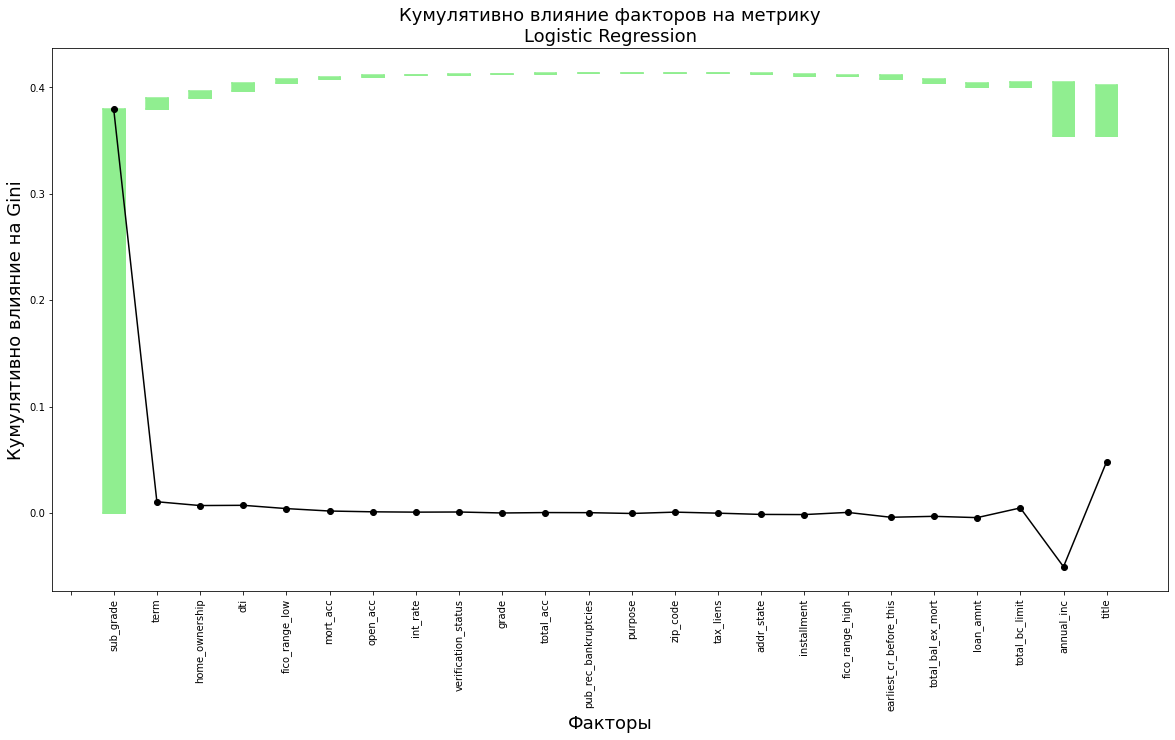

In [38]:
gini_select(x_train = X_train.iloc[:200000], 
            x_val = X_val.reset_index().drop(columns='index').iloc[:200000], 
            y_train = y_train.iloc[:200000], 
            y_val = y_val.reset_index().loan_status.iloc[:200000], 
            factors = X_train.columns, 
            model_type = "logreg")

100%|██████████| 24/24 [00:02<00:00, 11.65it/s]


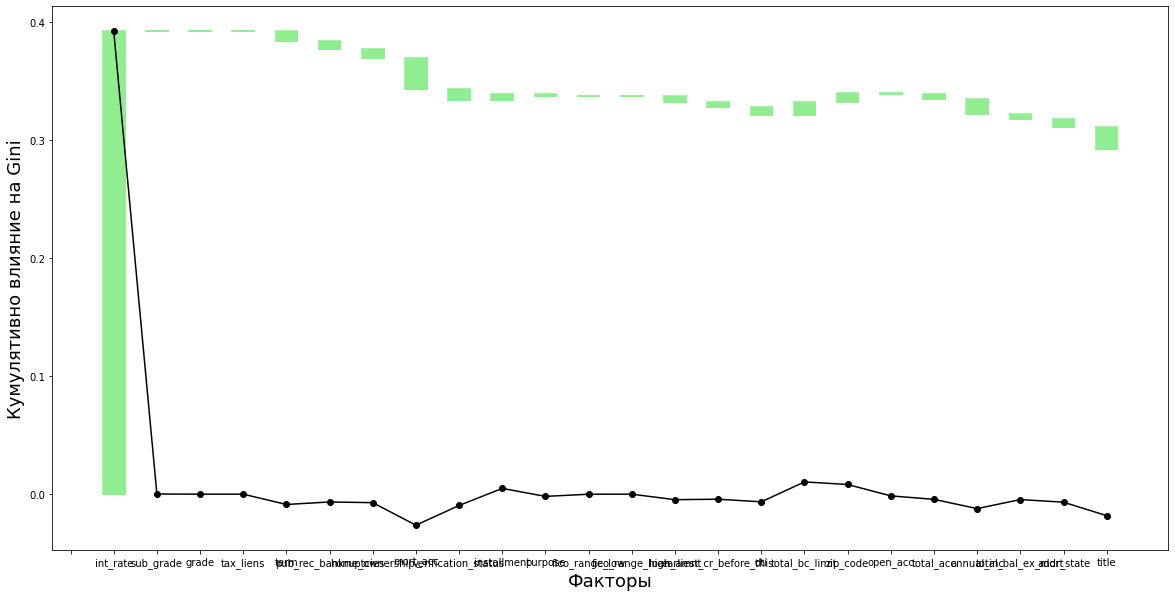

In [39]:
gini_select(x_train = X_train.iloc[:3000], 
            x_val = X_val.reset_index().drop(columns='index').iloc[:3000], 
            y_train = y_train.iloc[:3000], 
            y_val = y_val.reset_index().loan_status.iloc[:3000], 
            factors = X_train.columns, 
            model_type="gbm")

### 5. а) Дескретезация предсказаний

In [ ]:
LR.fit(X_global_train_lr, y_global_train_lr)
y_preds_train_lr = LR.predict_proba(X_global_train_lr)[:, 1]
y_preds_lr = LR.predict_proba(X_test_lr)[:, 1]

gbm.fit(X_global_train, y_global_train)
y_preds_train_gbm = gbm.predict_proba(X_global_train)[:, 1]
y_preds_gbm = gbm.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.isotonic import IsotonicRegression

ir_lr = IsotonicRegression(out_of_bounds='clip')
ir_lr.fit(y_preds_train_lr, y_global_train_lr)

ir_gbm = IsotonicRegression(out_of_bounds='clip')
ir_gbm.fit(y_preds_train_gbm, y_global_train)

In [ ]:
def get_bins(y_true: np.ndarray, y_pred: np.ndarray, q: int=10) -> list:
    _, q_bins = pd.qcut(y_pred, q=q, retbins=True)
    q_bins[0] = 0
    y_idx_bins = []
    for i in tqdm(range(len(q_bins) - 1)):
        idx = np.argwhere(np.logical_and(y_pred > q_bins[i], y_pred <= q_bins[i+1]))
        y_idx_bins.append(idx)
    return y_idx_bins

In [ ]:
y_idx_bins_lr = get_bins(y_test, ir_lr.predict(y_preds_lr), q=5)
y_idx_bins_gbm = get_bins(y_test, ir_gbm.predict(y_preds_gbm), q=5)

###  5. b) Разделяющая способность

In [ ]:
def show_pred_dist(y_true: np.ndarray, y_pred: np.ndarray, name: str, threshold: float=0.5) -> None:
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot()
    
    sns.distplot(y_pred[y_true == 1], ax=ax, label='true')
    sns.distplot(y_pred[y_true == 0], ax=ax, label='false')
    ax.axvline(threshold, ls='--', label='threshold')
    
    plt.title('Разделяющая способность, {}'.format(name))
    plt.legend()
    plt.show()
    

In [ ]:
show_pred_dist(y_test, ir_lr.predict(y_preds_lr), 'LogReg + Isotonic')

In [ ]:
show_pred_dist(y_test, ir_gbm.predict(y_preds_gbm), 'LightGBM + Isotonic')

### 5.  c) Переобучение. Нет ли признаков переобучения модели?

              precision    recall  f1-score   support

           0       0.88      0.67      0.76    840500
           1       0.33      0.64      0.43    209157

    accuracy                           0.67   1049657
   macro avg       0.60      0.65      0.60   1049657
weighted avg       0.77      0.67      0.70   1049657



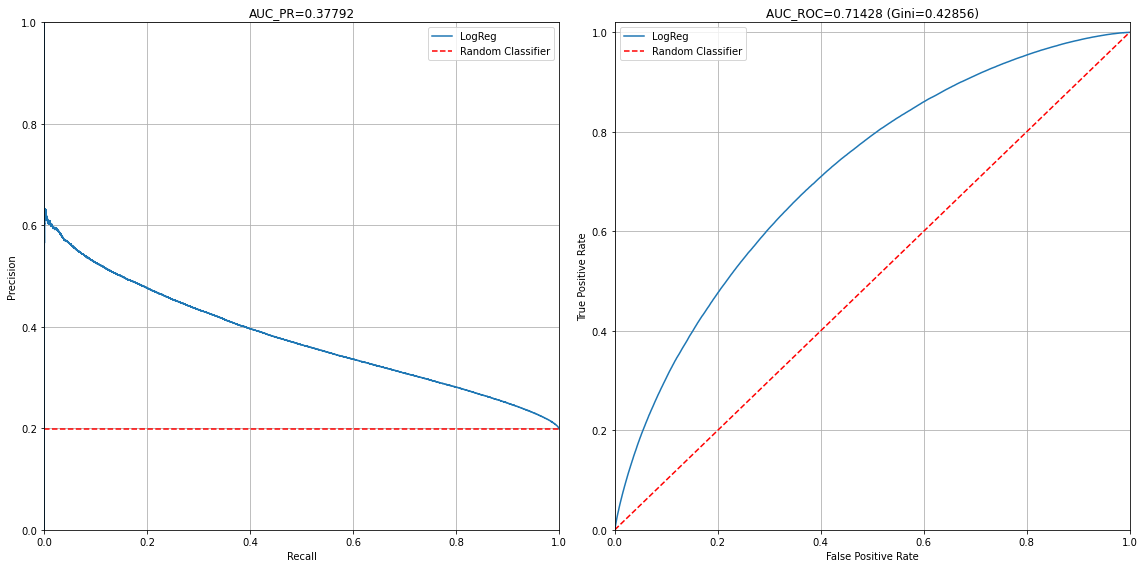

In [47]:
LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
results, pred = get_results(model=LR, data_summary=results, 
                            train_x = X_global_train_lr, 
                            train_y = y_global_train_lr, 
                            test_x = X_global_train_lr, 
                            test_y = y_global_train_lr, 
                            cat_feat = None, 
                            column_name = 'Log_Reg_train', 
                            name_model = 'LogReg',  
                            mode = 'logreg')

In [48]:
results

,random_classifier,Log_Reg,LightGBM,Log_Reg_train
Precision,0.500000,0.607630,0.611260,0.603833
Recall,0.500000,0.643622,0.655983,0.654631
AUC-PR,0.199262,0.390078,0.405594,0.377932
AUC-ROC,0.500000,0.704576,0.714764,0.714283
Gini,0.000000,0.409152,0.429528,0.428566
F1_score,0.500000,0.607647,0.600850,0.597253
Accuracy,0.680886,0.672331,0.649326,0.665624


              precision    recall  f1-score   support

           0       0.90      0.66      0.76    840500
           1       0.34      0.71      0.46    209157

    accuracy                           0.67   1049657
   macro avg       0.62      0.68      0.61   1049657
weighted avg       0.79      0.67      0.70   1049657



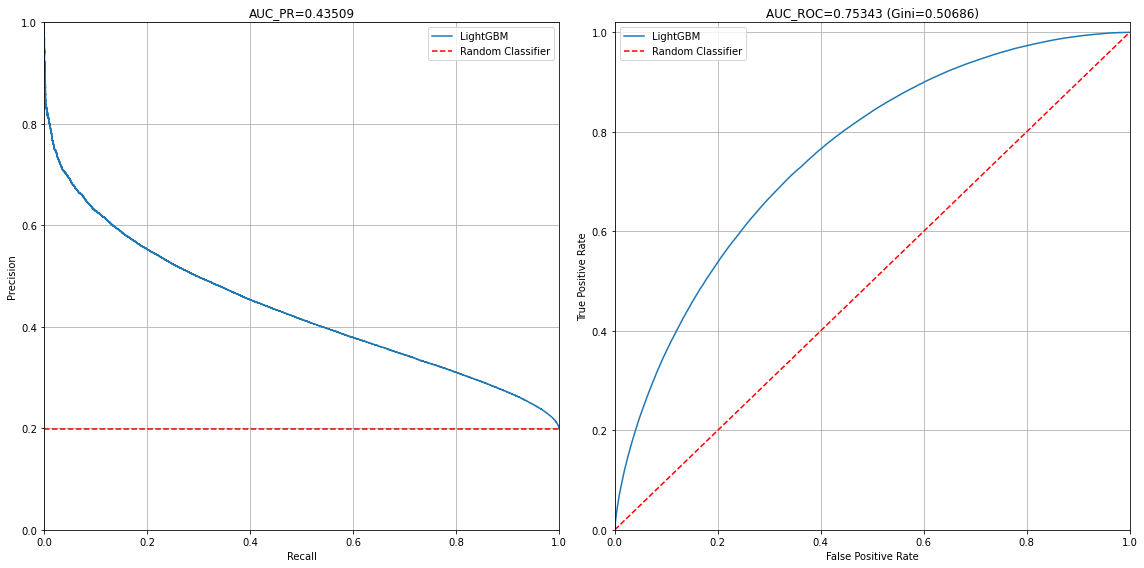

In [49]:
gbm = LGBMClassifier(**param)
results, pred = get_results(model=gbm, data_summary=results, 
                            train_x = X_global_train, 
                            train_y = y_global_train, 
                            test_x = X_global_train, 
                            test_y = y_global_train, 
                            cat_feat = category, 
                            column_name = 'LightGBM_train', 
                            name_model = 'LightGBM',  
                            mode = 'gbm')

In [50]:
results

,random_classifier,Log_Reg,LightGBM,Log_Reg_train,LightGBM_train
Precision,0.500000,0.607630,0.611260,0.603833,0.621885
Recall,0.500000,0.643622,0.655983,0.654631,0.684821
AUC-PR,0.199262,0.390078,0.405594,0.377932,0.435090
AUC-ROC,0.500000,0.704576,0.714764,0.714283,0.753434
Gini,0.000000,0.409152,0.429528,0.428566,0.506867
F1_score,0.500000,0.607647,0.600850,0.597253,0.612918
Accuracy,0.680886,0.672331,0.649326,0.665624,0.671941


### 5.  d) Простота модели. Нельзя ли упростить модель, не сильно потеряв при этом в качестве?

Дропаем:
- pub_rec_bankruptcies	
- tax_liens	
- fico_range_high	

In [51]:
col_drop = feature_sorted[feature_sorted.importance < 4e+04].feature_name

X_test = X_test.drop(col_drop, axis=1)
X_test_lr = X_test_lr.drop(col_drop, axis=1)
X_global_train = X_global_train.drop(col_drop, axis=1)
X_global_train_lr = X_global_train_lr.drop(col_drop, axis=1)

LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
LR.fit(X_global_train_lr, y_global_train_lr)
y_preds_lr = LR.predict_proba(X_test_lr)[:, 1]

gbm = LGBMClassifier(**param)
gbm.fit(X_global_train, y_global_train)
y_preds_gbm = gbm.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.85      0.70      0.77    155310
           1       0.36      0.59      0.45     45127

    accuracy                           0.67    200437
   macro avg       0.61      0.64      0.61    200437
weighted avg       0.74      0.67      0.70    200437



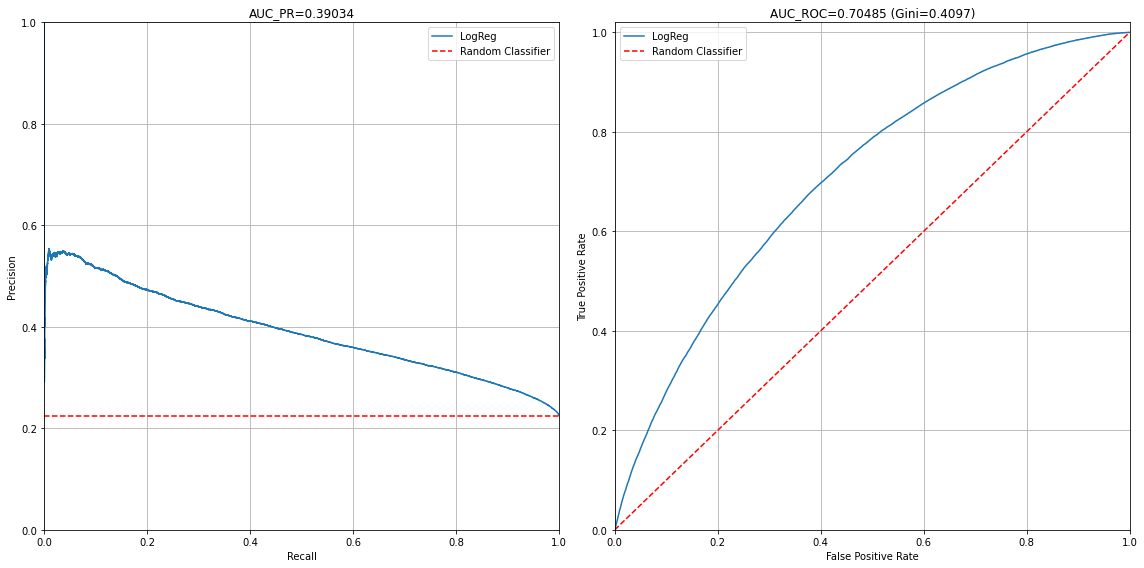

In [52]:
LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
results, pred = get_results(model=LR, data_summary=results, 
                              train_x = X_global_train_lr, 
                              train_y = y_global_train_lr, 
                              test_x = X_test_lr, 
                              test_y = y_test_lr, 
                              cat_feat = None, 
                              column_name = 'Log_Reg_drop', 
                              name_model = 'LogReg',  
                              mode = 'logreg')

In [53]:
results

,random_classifier,Log_Reg,LightGBM,Log_Reg_train,LightGBM_train,Log_Reg_drop
Precision,0.500000,0.607630,0.611260,0.603833,0.621885,0.607809
Recall,0.500000,0.643622,0.655983,0.654631,0.684821,0.643767
AUC-PR,0.199262,0.390078,0.405594,0.377932,0.435090,0.390363
AUC-ROC,0.500000,0.704576,0.714764,0.714283,0.753434,0.704851
Gini,0.000000,0.409152,0.429528,0.428566,0.506867,0.409702
F1_score,0.500000,0.607647,0.600850,0.597253,0.612918,0.607928
Accuracy,0.680886,0.672331,0.649326,0.665624,0.671941,0.672750


              precision    recall  f1-score   support

           0       0.87      0.64      0.74    155310
           1       0.35      0.67      0.46     45127

    accuracy                           0.65    200437
   macro avg       0.61      0.66      0.60    200437
weighted avg       0.75      0.65      0.68    200437



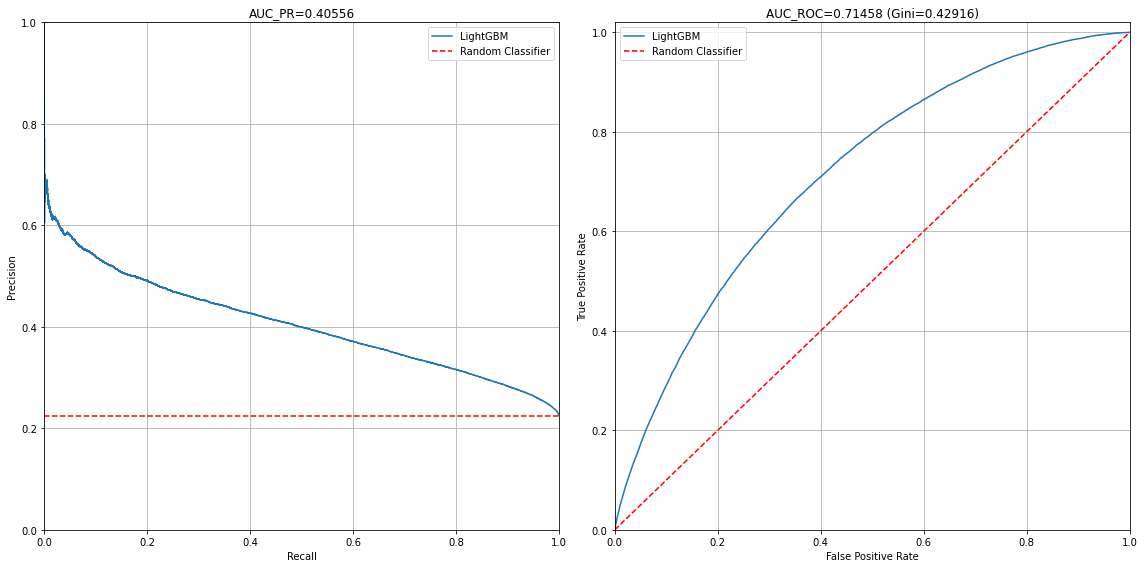

In [54]:
gbm = LGBMClassifier(**param)
results = get_results(model=gbm, data_summary=results, 
                      train_x = X_global_train, 
                      train_y = y_global_train, 
                      test_x = X_test, 
                      test_y = y_test, 
                      cat_feat = category, 
                      column_name = 'LightGBM_drop', 
                      name_model = 'LightGBM',  
                      mode = 'gbm')

In [55]:
results

(           random_classifier   Log_Reg  LightGBM  Log_Reg_train  \
 Precision           0.500000  0.607630  0.611260       0.603833   
 Recall              0.500000  0.643622  0.655983       0.654631   
 AUC-PR              0.199262  0.390078  0.405594       0.377932   
 AUC-ROC             0.500000  0.704576  0.714764       0.714283   
 Gini                0.000000  0.409152  0.429528       0.428566   
 F1_score            0.500000  0.607647  0.600850       0.597253   
 Accuracy            0.680886  0.672331  0.649326       0.665624   
 
            LightGBM_train  Log_Reg_drop  LightGBM_drop  
 Precision        0.621885      0.607809       0.611348  
 Recall           0.684821      0.643767       0.656175  
 AUC-PR           0.435090      0.390363       0.405586  
 AUC-ROC          0.753434      0.704851       0.714576  
 Gini             0.506867      0.409702       0.429151  
 F1_score         0.612918      0.607928       0.600773  
 Accuracy         0.671941      0.672750       0

### 5.  e) Устойчивость модели во времени? Будем использовать кроссвалидацию с расширающимся окном

In [22]:
def plot_tss_results(train_x: pd.DataFrame, train_y: pd.Series,
                     n_splits: int=5, model_type: str='logreg', cat_feat: list=None) -> tuple:
    
    assert model_type in ['logreg', 'gbm'], \
    "Mode value should be 'logreg' or 'gbm'! Yours value = '{}'".format(mode)
    
    ts_folds = TimeSeriesSplit(n_splits=n_splits)
    
    list_preds = []
    list_true = []
    list_X_te = []
    
    for i, (train_index, test_index) in tqdm(enumerate(ts_folds.split(train_x, train_y), 1)):
        
        X_tr, X_te = train_x.loc[train_index], train_x.loc[test_index]
        y_tr, y_te = train_y.loc[train_index], train_y.loc[test_index]
        
        list_X_te.append(X_te)
        
        if model_type == 'gbm':
            model_gbm = LGBMClassifier(**param)
            model_gbm.fit(X_tr, y_tr, feature_name=train_x.columns.tolist(), categorical_feature=cat_feat)
            pred_prob = model_gbm.predict_proba(X_te)[:, 1]
            
            plot_AUC([y_te], [pred_prob], "LightGBM, fold = {}".format(i))
            
            list_preds.append(pred_prob)
            list_true.append(y_te)
            
        else:
            model_lr = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
            model_lr.fit(X_tr, y_tr)
            pred_prob = model_lr.predict_proba(X_te)[:, 1]
            
            plot_AUC([y_te], [pred_prob], "LogReg, fold = {}".format(i))
            
            list_preds.append(pred_prob)
            list_true.append(y_te)
    
    return list_X_te, list_true, list_preds


0it [00:00, ?it/s]

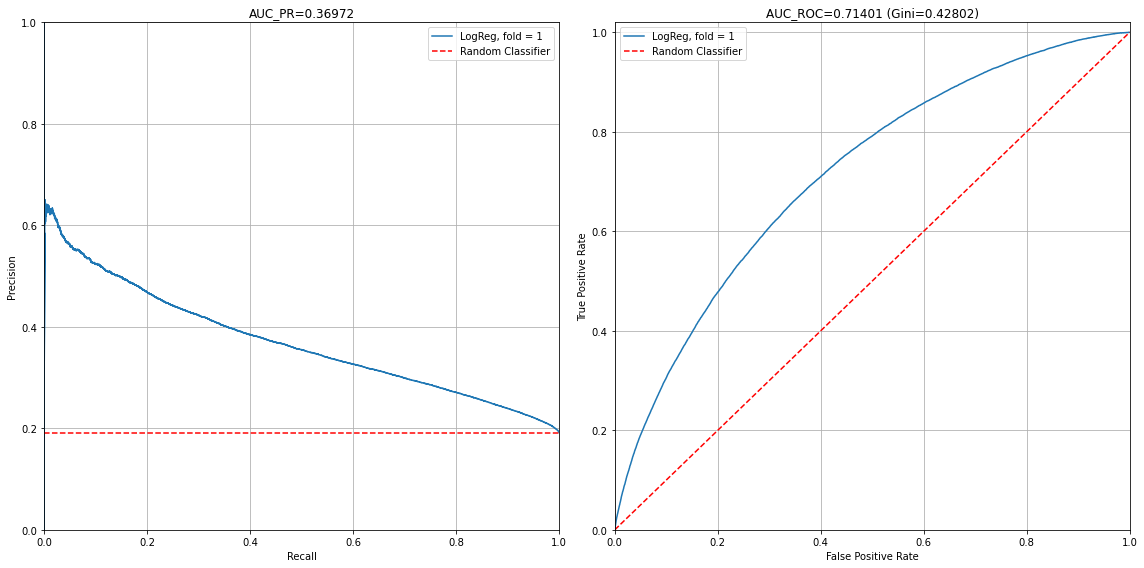

1it [00:04,  4.57s/it]

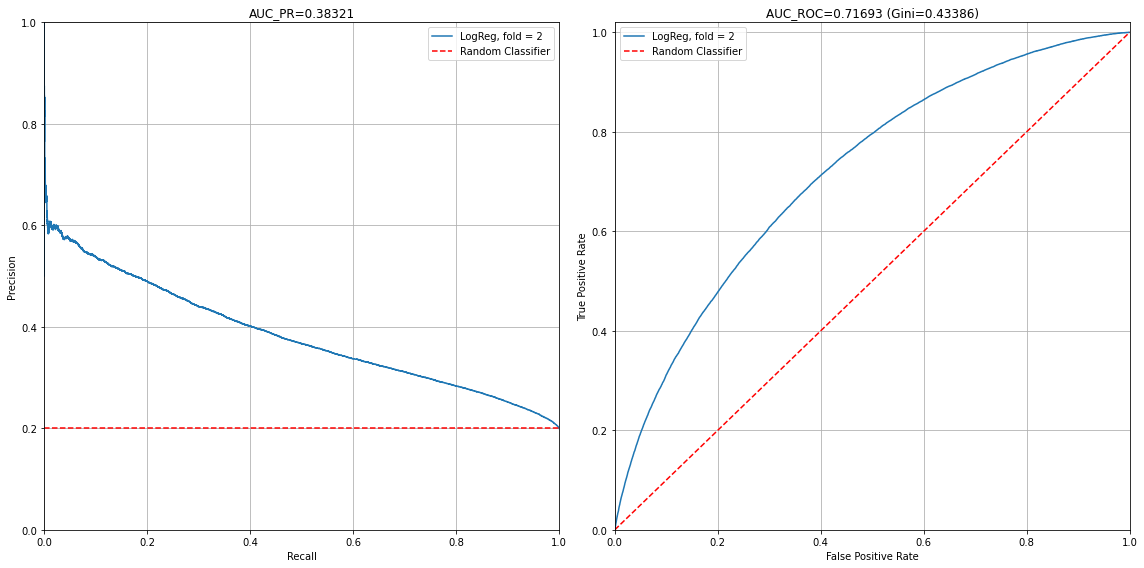

2it [00:13,  7.04s/it]

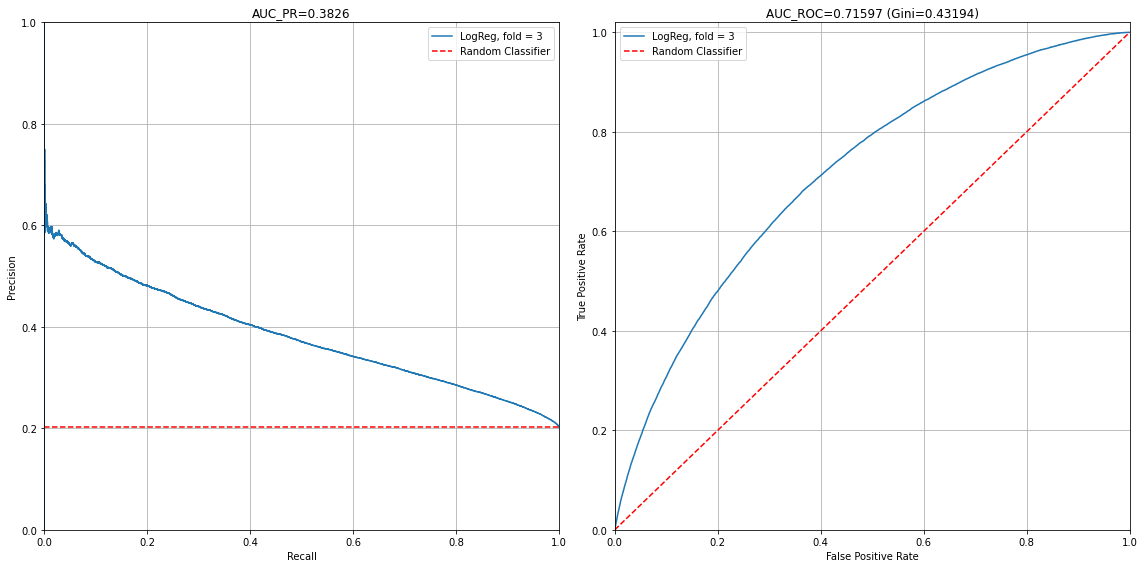

3it [00:26,  9.69s/it]

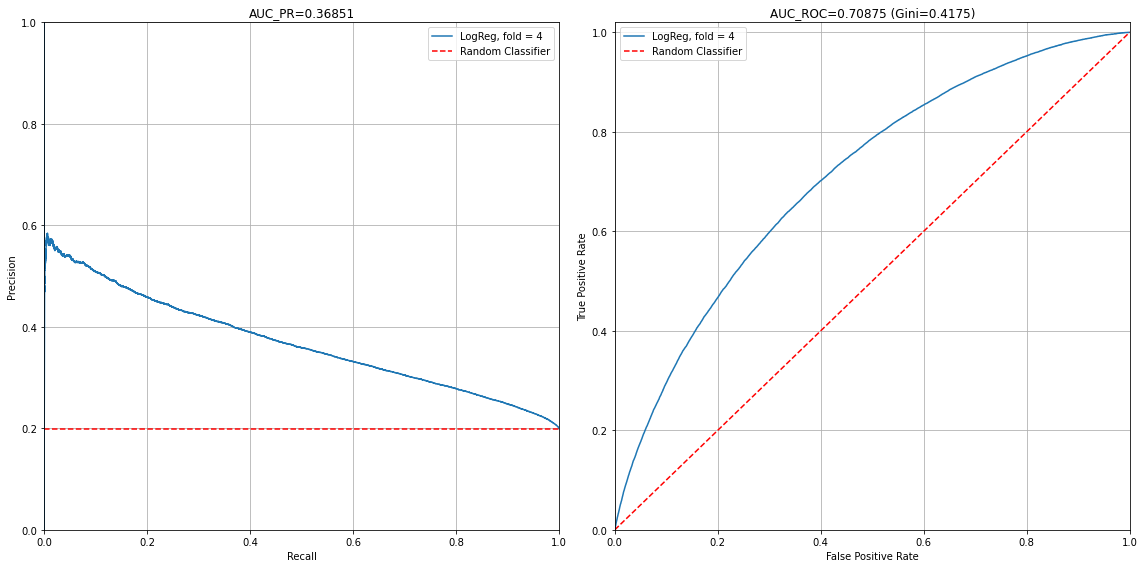

4it [00:43, 12.62s/it]

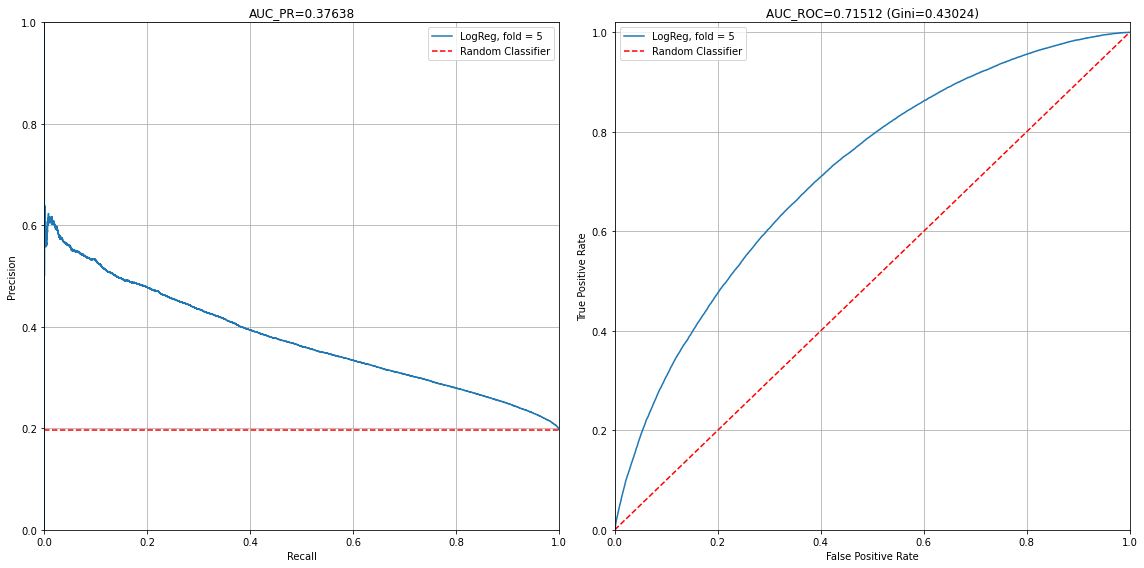

5it [01:04, 12.90s/it]


In [61]:
list_X_te, lr_ts_gt, lr_ts_preds = plot_tss_results(X_global_train_lr, y_global_train_lr, 5, 'logreg')

0it [00:00, ?it/s]

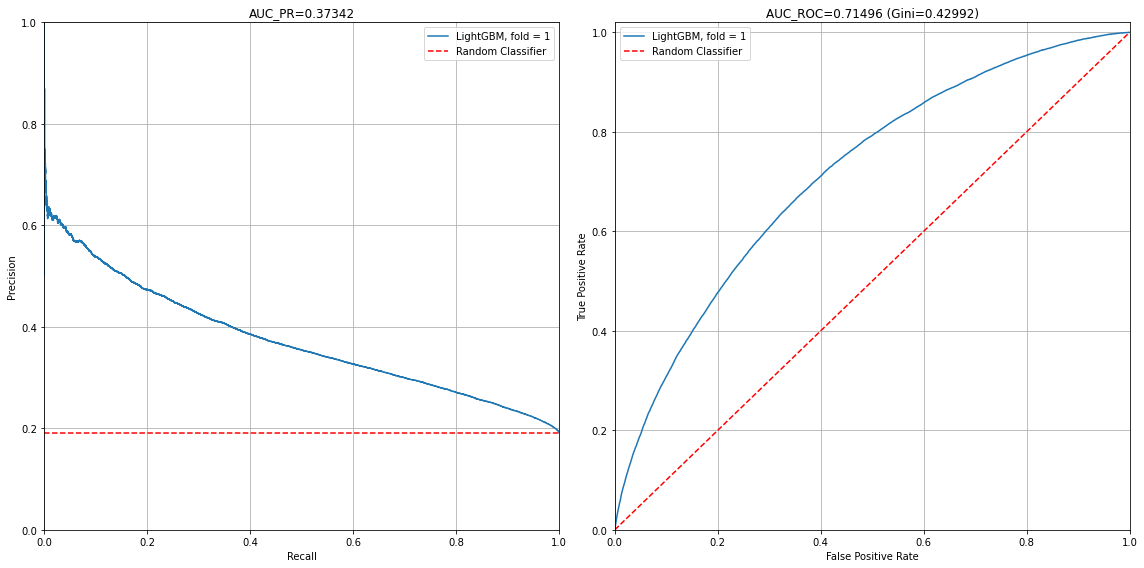

1it [00:18, 18.96s/it]

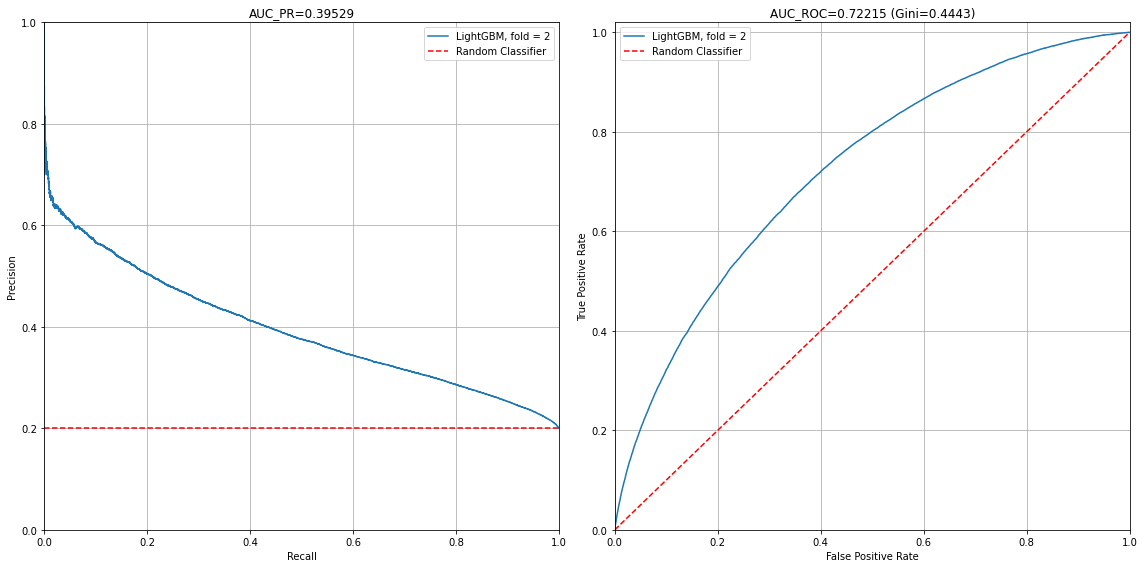

2it [00:43, 22.29s/it]

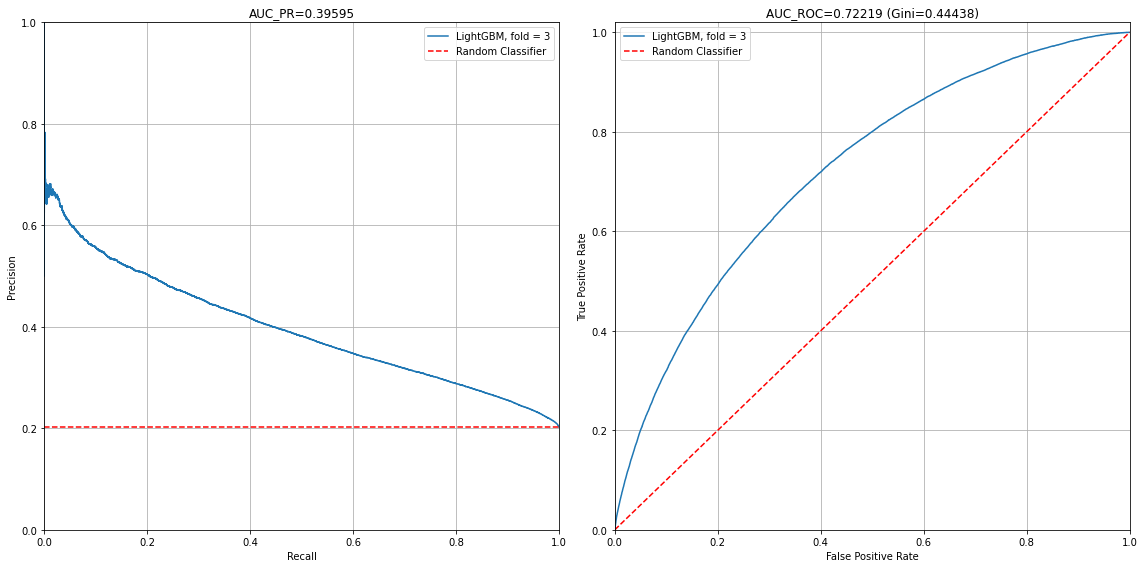

3it [01:18, 28.12s/it]

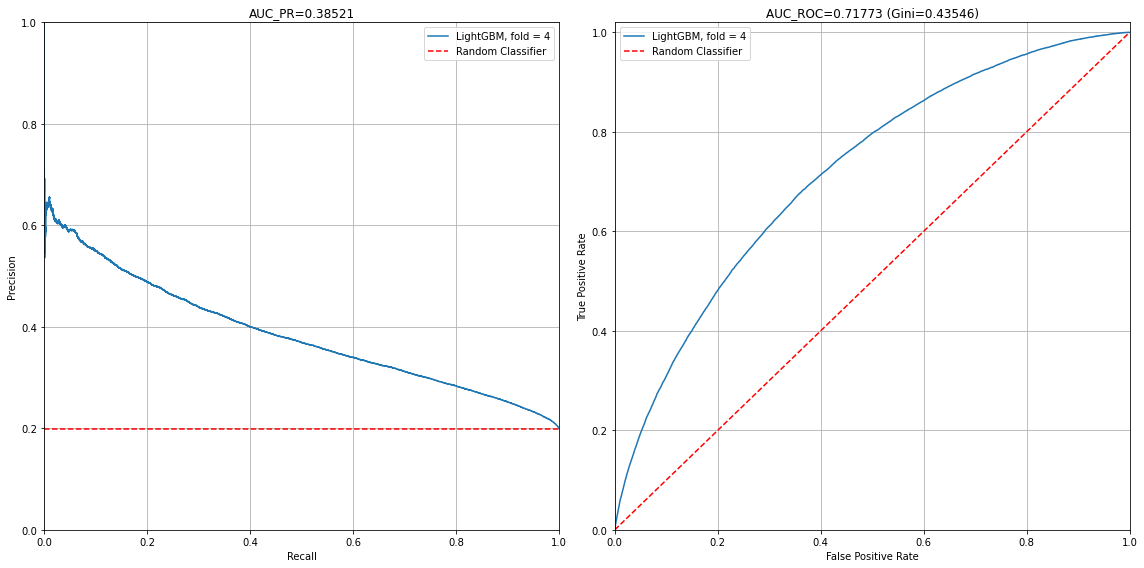

4it [02:08, 36.80s/it]

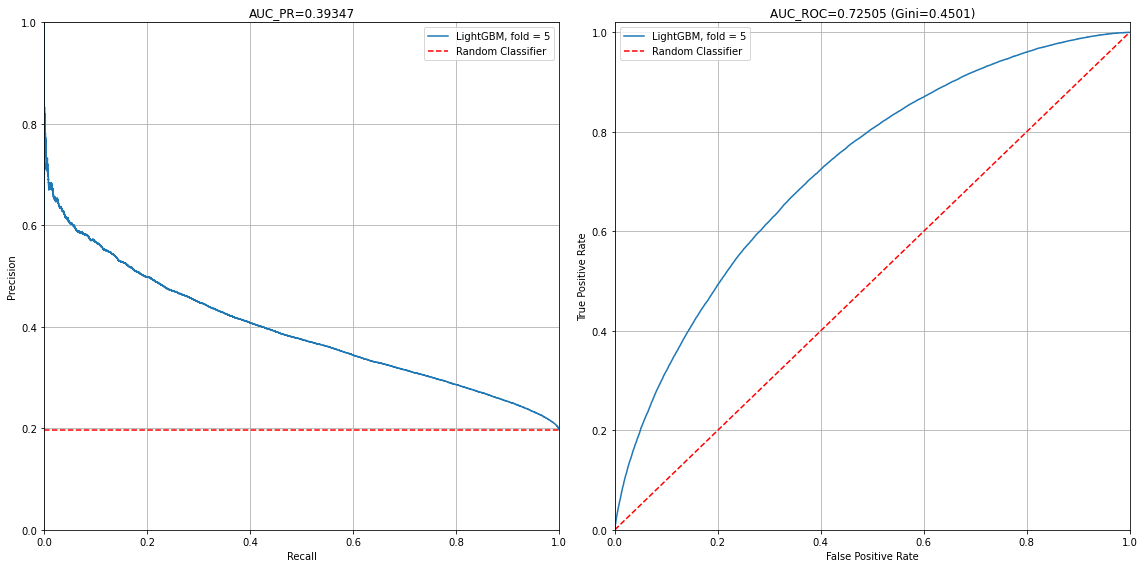

5it [03:16, 39.21s/it]


In [62]:
list_X_te, gbm_ts_gt, gbm_ts_preds = plot_tss_results(X_global_train, y_global_train, 5, 'gbm', category)

In [23]:
def get_metrics_by_bins(gt, preds, name):
    results = pd.DataFrame()
    for i in range(len(gt)):
        y_test = gt[i]
        y_pred_prob = preds[i]
        y_pred_binary = np.where(y_pred_prob > 0.5, 1, 0)
        metrics = compute_metrics(y_test, y_pred_binary, y_pred_prob)
        results[name + '_'+str(i)] = metrics
    results[name+'_mean'] = results.mean(axis=1)        
    results.index = ['Precision', 'Recall', 'AUC-PR', 'AUC-ROC', 'Gini', 'F1_score', 'Accuracy']
    return results

In [64]:
lr_res = get_metrics_by_bins(lr_ts_gt, lr_ts_preds, 'LogReg_TS')
gbm_res = get_metrics_by_bins(lr_ts_gt, lr_ts_preds, 'LightGBM_TS')

In [65]:
lr_res

,LogReg_TS_0,LogReg_TS_1,LogReg_TS_2,LogReg_TS_3,LogReg_TS_4,LogReg_TS_mean
Precision,0.601060,0.604045,0.606362,0.601558,0.603180,0.603241
Recall,0.656186,0.655960,0.656517,0.650978,0.654932,0.654914
AUC-PR,0.369760,0.383245,0.382639,0.368551,0.376423,0.376124
AUC-ROC,0.714011,0.716931,0.715970,0.708749,0.715115,0.714155
Gini,0.428023,0.433862,0.431940,0.417498,0.430230,0.428310
F1_score,0.591044,0.595486,0.601044,0.594795,0.595809,0.595636
Accuracy,0.660150,0.660882,0.668873,0.663626,0.664243,0.663555


In [66]:
gbm_res

,LightGBM_TS_0,LightGBM_TS_1,LightGBM_TS_2,LightGBM_TS_3,LightGBM_TS_4,LightGBM_TS_mean
Precision,0.601060,0.604045,0.606362,0.601558,0.603180,0.603241
Recall,0.656186,0.655960,0.656517,0.650978,0.654932,0.654914
AUC-PR,0.369760,0.383245,0.382639,0.368551,0.376423,0.376124
AUC-ROC,0.714011,0.716931,0.715970,0.708749,0.715115,0.714155
Gini,0.428023,0.433862,0.431940,0.417498,0.430230,0.428310
F1_score,0.591044,0.595486,0.601044,0.594795,0.595809,0.595636
Accuracy,0.660150,0.660882,0.668873,0.663626,0.664243,0.663555


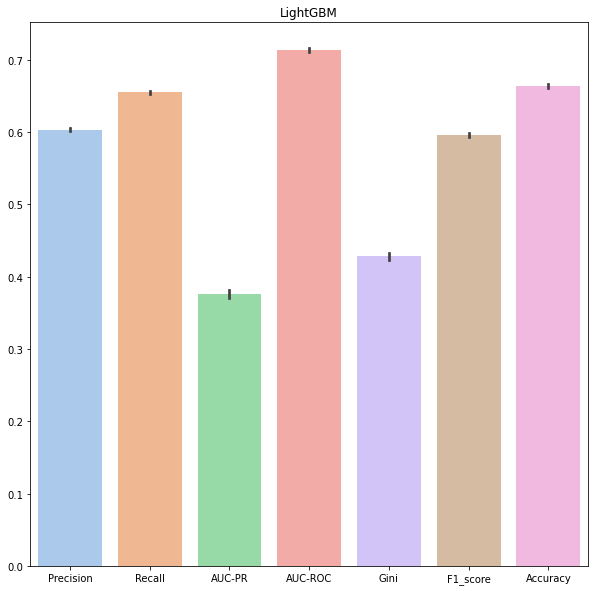

In [67]:
plt.figure(figsize=(10,10))
g = sns.barplot(data=gbm_res.drop(columns='LightGBM_TS_mean').T, palette='pastel', capsize =0, )
plt.title('LightGBM')
plt.show()

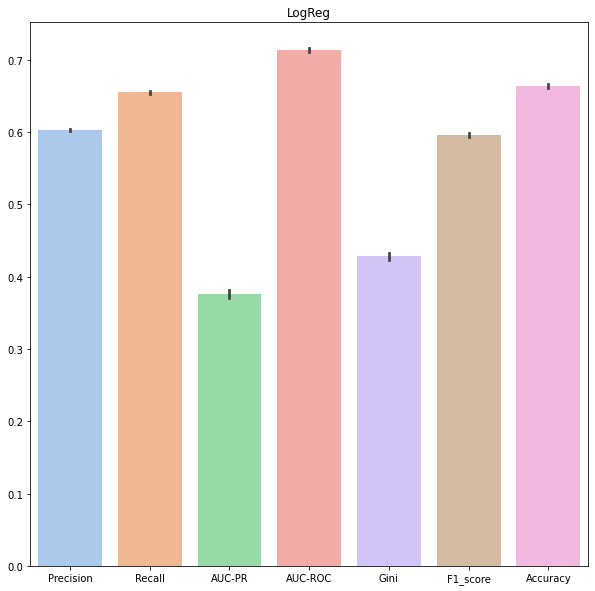

In [68]:
plt.figure(figsize=(10,10))
sns.barplot(data=lr_res.drop(columns='LogReg_TS_mean').T, palette='pastel', capsize =0)
plt.title('LogReg')
plt.show()

### 5. g) Корректность оценки PD

In [24]:
from scipy.stats import norm
def test_bin(labels: np.ndarray, scores: np.ndarray) -> list:
    pred_mean = labels.mean()
    true_mean = scores.mean()
    d = np.sqrt(true_mean * (1 - true_mean) / len(labels))
    results = [true_mean, pred_mean]
    for alpha in [0.01, 0.05]:
        u = norm.ppf(1 - alpha / 2) * d
        results.append((true_mean - u, true_mean + u))
    flag = (pred_mean >= results[-1][0]) and (pred_mean <= results[-1][1])
    results.append(flag)
    return results

In [25]:
def test_bernoulli(y_true: np.ndarray, y_pred: np.ndarray, idx_bins: np.ndarray):
    res = [test_bin(y_true[idx_bin], y_pred[idx_bin]) for idx_bin in idx_bins]
    return pd.DataFrame(data=res, columns=['true_mean', 'pred_mean', 'int_99', 'int_95', 'ans_95'])

In [ ]:
test_bernoulli_lr = test_bernoulli(y_test.to_numpy(), ir_lr.predict(y_preds_lr), idx_bins=y_idx_bins_lr)
test_bernoulli_gbm = test_bernoulli(y_test.to_numpy(), ir_gbm.predict(y_preds_lr), idx_bins=y_idx_bins_gbm)

In [ ]:
test_bernoulli_lr

In [ ]:
test_bernoulli_gbm

In [26]:
def plot_test_bernoulli(test_results: pd.DataFrame, name: str):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.subplot()
    
    x = test_results.index.values
    int_95 = np.array(list(test_results['int_95']))
    int_99 = np.array(list(test_results['int_99']))
    
    sns.lineplot(x=x, y=test_results['true_mean'], label='true', ax=ax)
    sns.scatterplot(x=x, y=test_results['pred_mean'], label='true', ax=ax, marker='x', color='red', s=100)
    ax.fill_between(x, int_99[:, 0], int_99[:, 1], alpha=0.1, color='yellow', label='int_99')
    ax.fill_between(x, int_95[:, 0], int_95[:, 1], alpha=0.1, color='green', label='int_95')
    
    plt.title("Тест бернулли, {}".format(name))
    plt.legend()
    plt.show()
    

In [ ]:
plot_test_bernoulli(test_bernoulli_lr, "LogReg")

In [ ]:
plot_test_bernoulli(test_bernoulli_gbm, "LightGBM")

## 6. Рассчет потерь и необходимого капитала

In [27]:
def bootstrap(X, preds, seed=None):
    pred = pd.DataFrame(preds)
    n = X.shape[0]
    X.index = range(n)
    pred.index = range(n) 
    np.random.seed(seed)
    idx = np.random.randint(0, n, n)
    return X.loc[idx], pred.loc[idx].values.reshape(-1)

### Подсчет интервалов Джини

In [79]:
def gini_interval(model, X: pd.DataFrame, y: pd.Series, n: int=1000):
    
    total_gini = []
    for step in tqdm(np.arange(n)): 
        X_, y_ = bootstrap(X, y)
        pred_prob = model.predict_proba(X_)[:, 1]
        Gini = 2 * roc_auc_score(y_, pred_prob) - 1
        total_gini.append(Gini)
        
    gini_lb95 = "{:0.4f}".format(np.quantile(total_gini, 0.025))
    gini_ub95 = "{:0.4f}".format(np.quantile(total_gini, 1-0.025))
    
    gini_lb99 = "{:0.4f}".format(np.quantile(total_gini, 0.005))
    gini_ub99 = "{:0.4f}".format(np.quantile(total_gini, 1-0.005))
        
    df_intervals = pd.DataFrame(columns = ["Mean", "95% conf.interval", "99% conf.interval"], index = ["Gini"])
    
    df_intervals.iloc[0, 0] = np.mean(total_gini)
    df_intervals.iloc[0, 1] = f"[{gini_lb95}; {gini_ub95}]"
    df_intervals.iloc[0, 2] = f"[{gini_lb99}; {gini_ub99}]"
    
    return total_gini, df_intervals

LR.fit(X_global_train_lr, y_global_train_lr)
gbm.fit(X_global_train, y_global_train)

Gini_lr_inter = gini_interval(LR, X_test_lr, y_test_lr, n=250)
Gini_gbm_inter = gini_interval(gbm, X_test, y_test, n=250)

100%|██████████| 250/250 [24:03<00:00,  5.77s/it]


### Логистическая регрессия без скелинга

100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


              precision    recall  f1-score   support

           0       0.85      0.69      0.76    155310
           1       0.35      0.58      0.43     45127

    accuracy                           0.66    200437
   macro avg       0.60      0.63      0.60    200437
weighted avg       0.74      0.66      0.69    200437



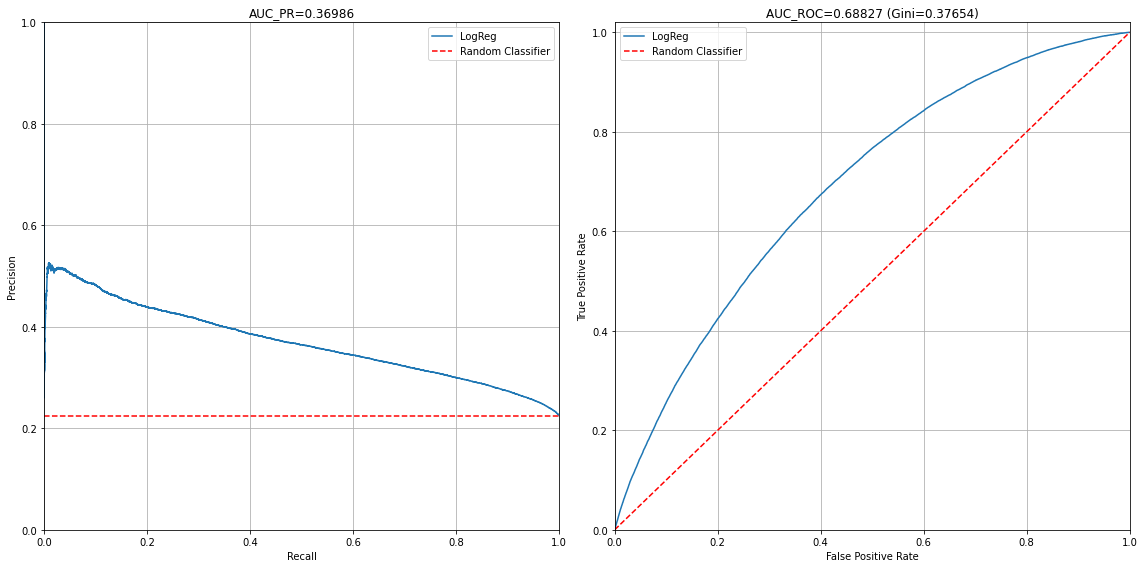

In [33]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state']

df = df[df.issue_d < np.datetime64('2018-06-01')].reset_index().drop('index', axis=1)
df = MultiColumnLabelEncoder(columns = cat).fit_transform(df)

enc = OneHotEncoder(drop='first', sparse=False)
for OHE in tqdm(OHE_cat):
    col = enc.fit_transform(df[OHE].values.reshape(-1, 1))
    hot_col = pd.DataFrame(col, columns=[OHE + '_' + str(i) for i in range(col.shape[1])])
    df = pd.concat([df, hot_col], axis=1)
    
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
train = df[df.issue_d < np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1).reset_index().drop(columns='index')
X_test_lr_no_Scale, y_test_lr_no_Scale = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

X_train_lr_no_Scale, X_val_lr_no_Scale = X.loc[train_inx], X.loc[val_inx]
X_global_train_lr_no_Scale = pd.concat([X_train_lr_no_Scale, X_val_lr_no_Scale], ignore_index=True)
y_train_lr_no_Scale, y_val_lr_no_Scale = y.loc[train_inx], y.loc[val_inx]
y_global_train_lr_no_Scale = pd.concat([y_train_lr_no_Scale, y_val_lr_no_Scale], ignore_index=True)

results, y_preds_lr_no_Scale = get_results(model=LR, data_summary=results, 
                                  train_x = X_global_train_lr_no_Scale, 
                                  train_y = y_global_train_lr_no_Scale, 
                                  test_x = X_test_lr_no_Scale, 
                                  test_y = y_test_lr_no_Scale, 
                                  cat_feat = None, 
                                  column_name = 'Log_Reg', 
                                  name_model = 'LogReg',  
                                  mode = 'logreg')

In [60]:
def plot_hist(pd, r, EAD, q, col='blue', dark='', new=True):
    if new: 
        plt.figure(figsize=(16, 8))
    np.random.seed(42)
    z = np.random.normal(size=len(pd))
    np.random.seed(42)
    a = st.norm.cdf((st.norm.ppf(pd)+np.sqrt(r)*z)/np.sqrt(1-r)) * EAD
    sns.distplot(a, hist=True, kde=True, 
             bins=100, color = col, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label=f'Distribution with r = {r}')
    plt.axvline(a.mean(), color=dark+'green', linestyle='--', label=f'Expecteed Loss with r = {r}', linewidth=3)
    plt.axvline(a.quantile(q), color=dark+'red', linestyle='--', label=f'Unxpecteed Loss with r = {r}',  linewidth=3)
    plt.title('Distribution of Potential Credit Losses')
    plt.xlabel('Potential Credit Loss')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(0)
    #plt.show()

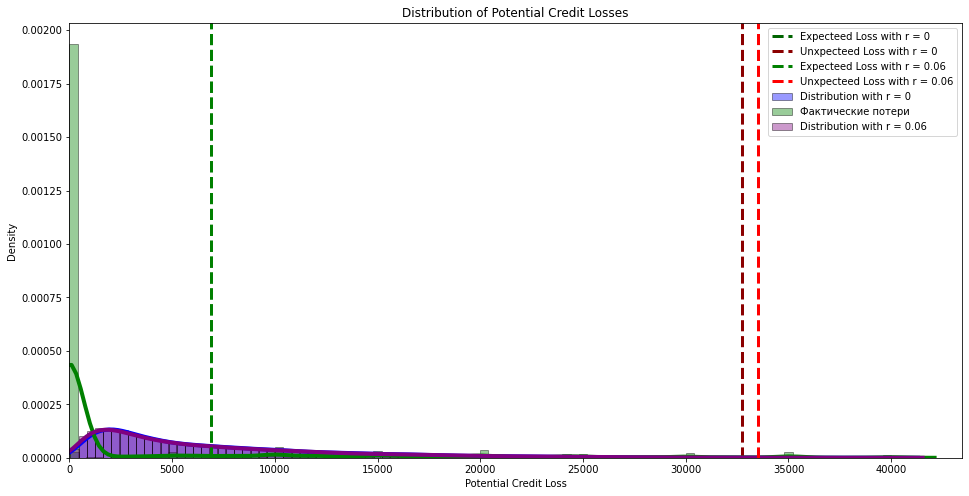

In [62]:
plot_hist(y_preds_lr_no_Scale, 0, X_test_lr_no_Scale['loan_amnt'], 0.999, "blue", 'dark') # ТУТ СТАВИМ НАШ ФИНАЛЬНЫЙ Х ТЕСТ 
sns.distplot(X_test_lr_no_Scale['loan_amnt'] * y_test_lr_no_Scale, hist=True, kde=True, 
             bins=100, color = 'g', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Фактические потери')
plot_hist(y_preds_lr_no_Scale, 0.06, X_test_lr_no_Scale['loan_amnt'], 0.999, col="purple", new=False)

plt.show()

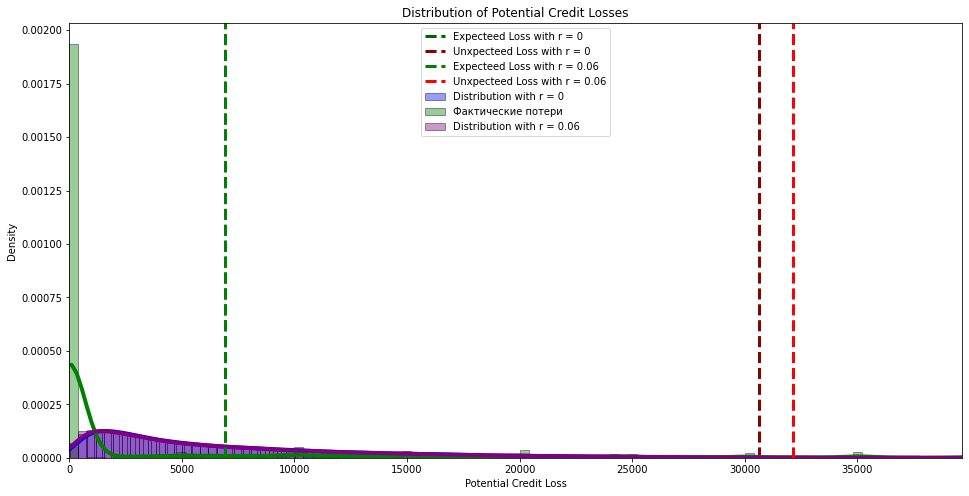

In [37]:
plot_hist(y_preds_gbm, 0, X_test['loan_amnt'], 0.999, "blue", 'dark') # ТУТ СТАВИМ НАШ ФИНАЛЬНЫЙ Х ТЕСТ 
sns.distplot(X_test['loan_amnt'] * y_test_lr, hist=True, kde=True, 
             bins=100, color = 'g', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Фактические потери')
plot_hist(y_preds_gbm, 0.06, X_test['loan_amnt'], 0.999, col="purple", new=False)

plt.show()

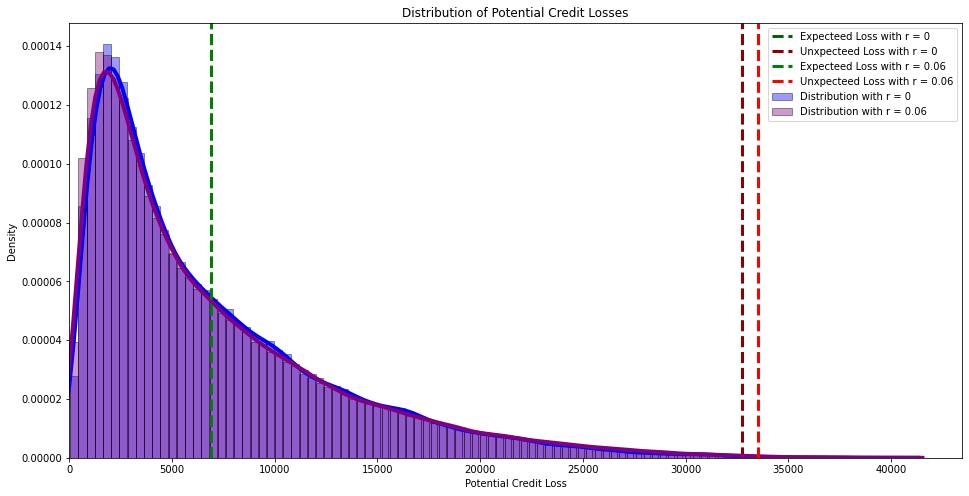

In [63]:
plot_hist(y_preds_lr_no_Scale, 0, X_test_lr_no_Scale['loan_amnt'], 0.999, "blue", 'dark') # ТУТ СТАВИМ НАШ ФИНАЛЬНЫЙ Х ТЕСТ 
plot_hist(y_preds_lr_no_Scale, 0.06, X_test_lr_no_Scale['loan_amnt'], 0.999, col="purple", new=False)

plt.show()

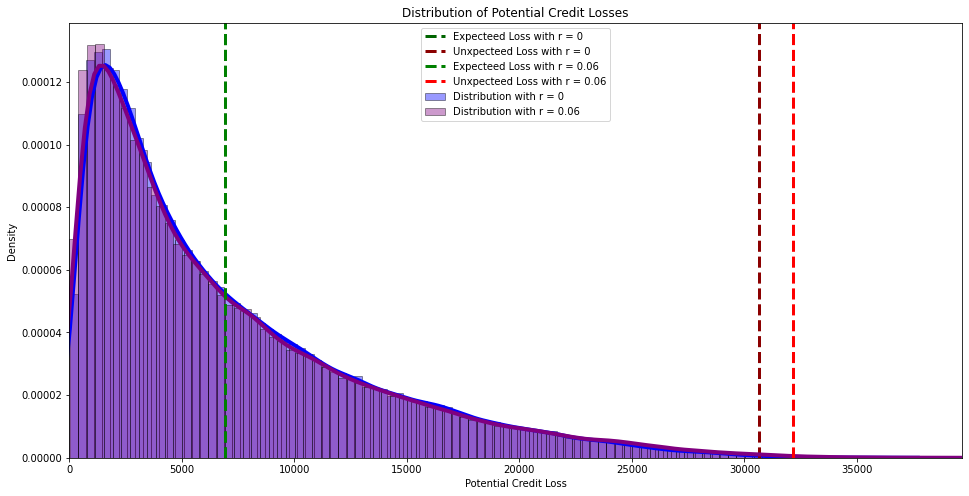

In [39]:
plot_hist(y_preds_gbm, 0, X_test['loan_amnt'], 0.999, "blue", 'dark') # ТУТ СТАВИМ НАШ ФИНАЛЬНЫЙ Х ТЕСТ 
plot_hist(y_preds_gbm, 0.06, X_test['loan_amnt'], 0.999, col="purple", new=False)

plt.show()

In [30]:
def calc_el_uel(pds, r, EAD, q, seed=None):
    np.random.seed(seed)
    z = np.random.normal(size=len(pds))
    np.random.seed(seed)
    a = st.norm.cdf((st.norm.ppf(pds)+np.sqrt(r)*z)/np.sqrt(1-r)) * EAD
    EL = a.mean()
    UEL = np.quantile(a, q)
    return (EL, UEL)

def plot_norm_dist(dist, name, r=0, cl=None): 
    mean, sigma  = st.distributions.norm.fit(dist)
    x = np.linspace(np.min(dist), np.max(dist), 10000)
    fitted_data = st.distributions.norm.pdf(x, mean, sigma)
    plt.plot(x, fitted_data, label='Normal Distribution', linewidth=2)
    if cl: 
        ub = np.round(np.quantile(x, (1+cl)/2), 2)
        lb = np.round(np.quantile(x, (1-cl)/2), 2)
        plt.axvline(ub, label=f'{cl*100}% Confidence Interval', color='grey', linestyle='--')
        plt.axvline(lb, color='grey', linestyle='--')
        plt.title(f'Distribution of {name} with r = {r} \n mean={np.round(mean, 2)} \n lower bound={lb}, upper bound={ub}')
    plt.legend(loc='upper left')
    print(name+' at r = {}:'.format(r))
    print([round(lb, 2), round(ub, 2)])
    
def plot_bs_hist(dist, name, r, color='darkblue', cl=0.99):
    sns.distplot(dist, hist=True, kde=True, 
             bins=10, color = color, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    plot_norm_dist(dist, name, r, cl)

In [36]:
def get_plot_data_BS(X_test, y_preds, n_iter = 1000):
    els, uels, req_cap, els_corr, uels_corr, req_cap_corr = [[] for x in range(6)]

    for i in tqdm(range(n_iter)):
        X_bs, pds = bootstrap(X_test, y_preds, seed=i)   # ТУТ СТАВИМ НАШ ФИНАЛЬНЫЙ Х ТЕСТ 
        el, uel = calc_el_uel(pds, 0, X_bs['loan_amnt'].values, 0.999, seed=i)
        el_corr, uel_corr = calc_el_uel(pds, 0.06, X_bs['loan_amnt'].values, 0.999, seed=i)

        els_corr.append(el_corr)
        uels_corr.append(uel_corr)
        req_cap_corr.append(uel_corr - el_corr)

        els.append(el)
        uels.append(uel)
        req_cap.append(uel - el)
        
    return els, uels, req_cap, els_corr, uels_corr, req_cap_corr

def stat_tests(els, uels, req_cap, els_corr, uels_corr, req_cap_corr, alpha=0.01):
    print('D’Agostino and Pearson’s normality test')
    print()
    print('Null hypothesis: x comes from a normal distribution')
    print(f'alpha = {alpha}')
    print()

    for dist, name in zip([els, uels, req_cap, els_corr, uels_corr, req_cap_corr], 
                    ['Expected Loss', 'Unexpected Loss', 'Required Capital',
                    'Expected Loss with correlation', 'Unexpected Loss with correlation', 'Required Capital with correlation']):
        statistics, p = st.normaltest(dist)
        if p < alpha:  
            print(f"{name}: The null hypothesis can be rejected")
        else:
            print(f"{name}: The null hypothesis cannot be rejected")

def plot_hitograms(els, uels, req_cap, els_corr, uels_corr, req_cap_corr):
    plt.figure(figsize=(21, 14))
    plt.subplot(2, 3, 1)
    plot_bs_hist(els, 'Expected Loss', 0, color='darkgreen')
    plt.subplot(2, 3, 2)
    plot_bs_hist(uels, 'Unexpected Loss', 0, color='darkred')
    plt.subplot(2, 3, 3)
    plot_bs_hist(req_cap, 'Required Capital', 0, color='darkblue')
    plt.subplot(2, 3, 4)
    plot_bs_hist(els_corr, 'Expected Loss', 0.06, color='darkgreen')
    plt.subplot(2, 3, 5)
    plot_bs_hist(uels_corr, 'Unexpected Loss', 0.06, color='darkred')
    plt.subplot(2, 3, 6)
    plot_bs_hist(req_cap_corr, 'Required Capital', 0.06, color='darkblue')
    plt.show()

In [58]:
X_test_lr

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,addr_state_40,addr_state_41,addr_state_42,addr_state_43,addr_state_44,addr_state_45,addr_state_46,addr_state_47,addr_state_48,addr_state_49
0,0.179487,0.0,0.454616,0.177383,0.500000,0.441176,1.0,0.122886,0.5,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.743590,0.0,0.678613,0.729324,0.666667,0.588235,0.2,0.188230,0.5,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.035897,0.0,0.289053,0.047874,0.333333,0.294118,0.8,0.148019,0.5,0.083333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.673718,1.0,0.678613,0.480958,0.666667,0.588235,0.8,0.153045,1.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.692308,1.0,0.415660,0.427749,0.333333,0.411765,1.0,0.248547,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200432,0.065385,0.0,0.992209,0.093242,1.000000,0.882353,1.0,0.105294,0.5,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
200433,0.358974,0.0,0.760810,0.373602,0.666667,0.647059,0.8,0.078905,1.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200434,0.358974,0.0,0.571874,0.349709,0.500000,0.529412,0.2,0.160565,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200435,0.487179,0.0,0.992209,0.539744,1.000000,0.882353,1.0,0.117860,1.0,0.166667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
els_lr, uels_lr, req_cap_lr, els_corr_lr, uels_corr_lr, req_cap_corr_lr = get_plot_data_BS(X_test_lr_no_Scale, 
                                                                                           y_preds_lr_no_Scale)

  0%|          | 1/1000 [00:00<05:01,  3.31it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 711


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


Expected Loss at r = 0:
[6841.07, 6951.69]
Unexpected Loss at r = 0:
[32276.51, 33523.49]
Required Capital at r = 0:
[25404.32, 26624.11]
Expected Loss at r = 0.06:
[6840.77, 6948.13]
Unexpected Loss at r = 0.06:
[33103.85, 33932.31]
Required Capital at r = 0.06:
[26198.48, 27032.78]


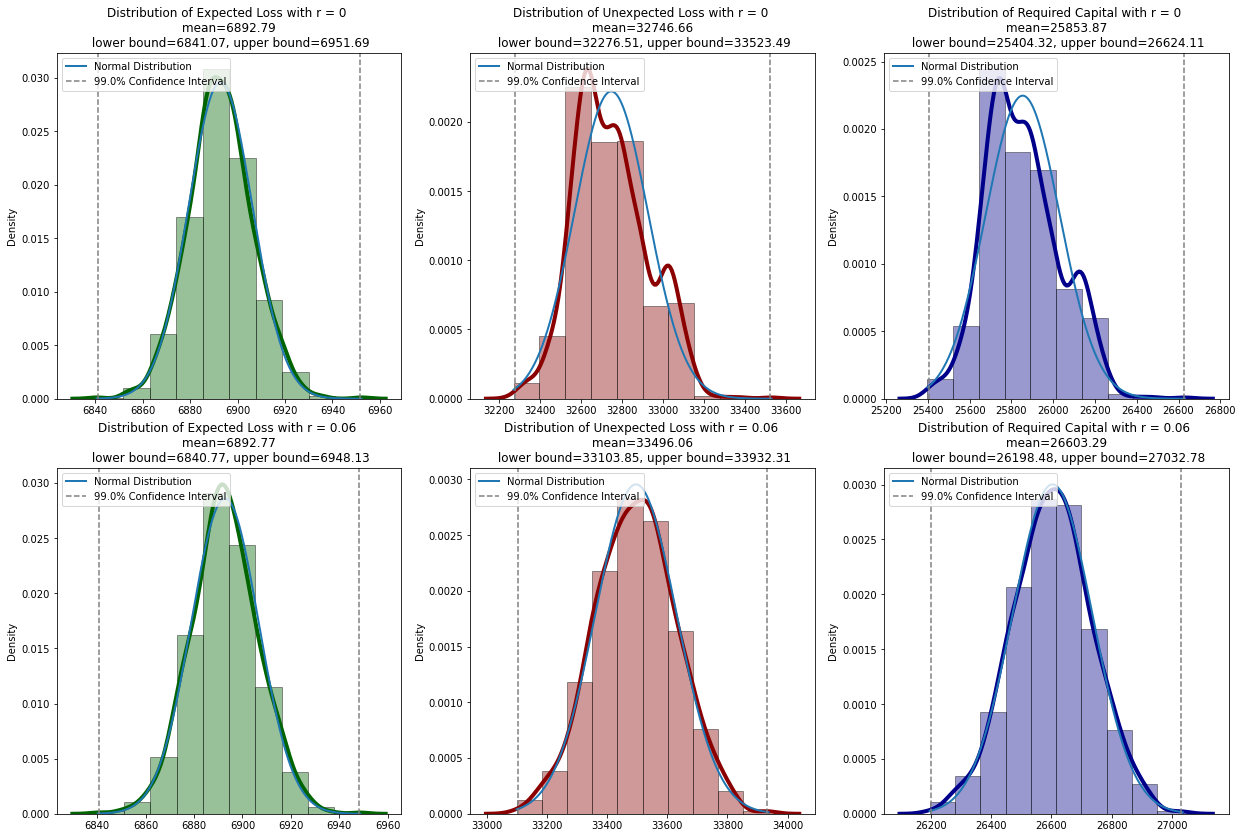

In [37]:
plot_hitograms(els_lr, uels_lr, req_cap_lr, els_corr_lr, uels_corr_lr, req_cap_corr_lr)

In [38]:
stat_tests(els_lr, uels_lr, req_cap_lr, els_corr_lr, uels_corr_lr, req_cap_corr_lr)

D’Agostino and Pearson’s normality test

Null hypothesis: x comes from a normal distribution
alpha = 0.01

Expected Loss: The null hypothesis cannot be rejected
Unexpected Loss: The null hypothesis can be rejected
Required Capital: The null hypothesis can be rejected
Expected Loss with correlation: The null hypothesis cannot be rejected
Unexpected Loss with correlation: The null hypothesis cannot be rejected
Required Capital with correlation: The null hypothesis cannot be rejected


In [39]:
els_gbm, uels_gbm, req_cap_gbm, els_corr_gbm, uels_corr_gbm, req_cap_corr_gbm = get_plot_data_BS(X_test, y_preds_gbm)

100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


Expected Loss at r = 0:
[6852.15, 6953.24]
Unexpected Loss at r = 0:
[30295.46, 30857.64]
Required Capital at r = 0:
[23397.72, 23960.38]
Expected Loss at r = 0.06:
[6852.5, 6949.68]
Unexpected Loss at r = 0.06:
[31756.54, 32424.17]
Required Capital at r = 0.06:
[24865.44, 25523.31]


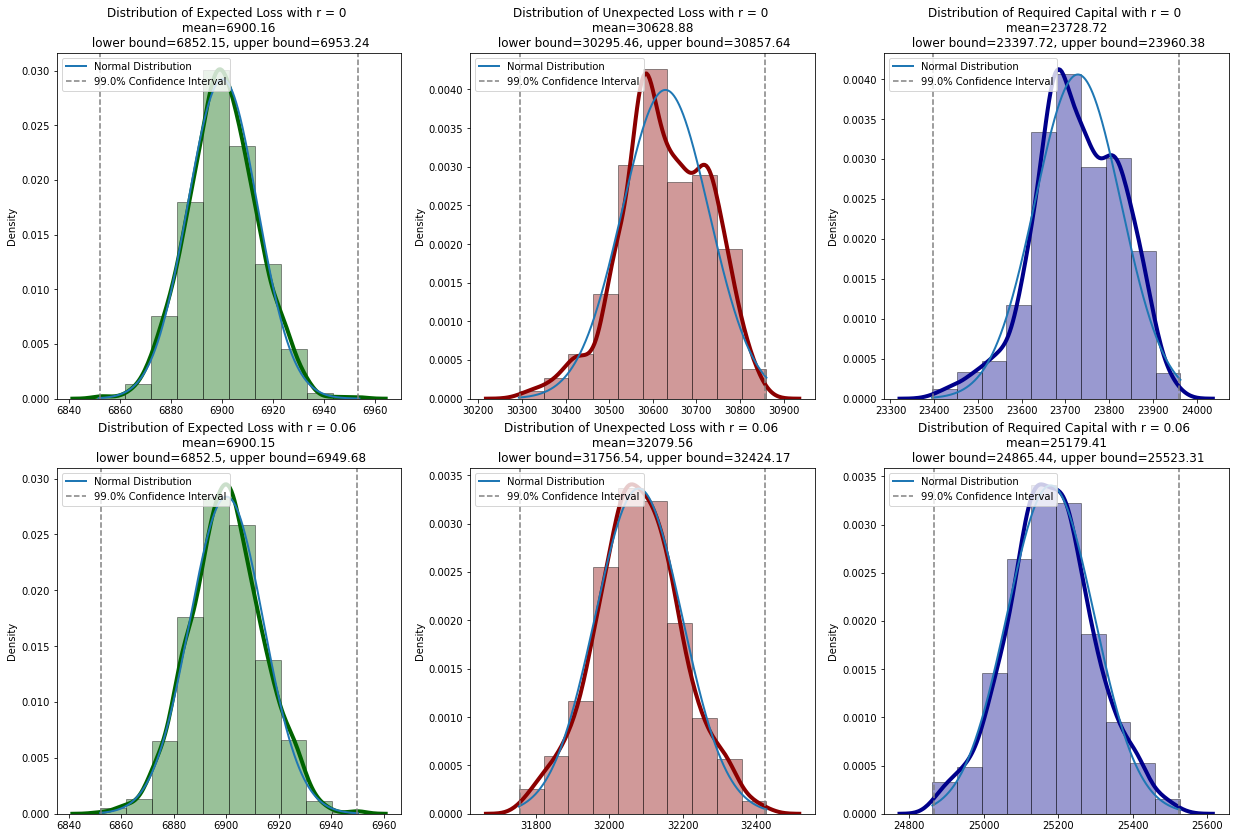

In [40]:
plot_hitograms(els_gbm, uels_gbm, req_cap_gbm, els_corr_gbm, uels_corr_gbm, req_cap_corr_gbm)

In [41]:
stat_tests(els_gbm, uels_gbm, req_cap_gbm, els_corr_gbm, uels_corr_gbm, req_cap_corr_gbm)

D’Agostino and Pearson’s normality test

Null hypothesis: x comes from a normal distribution
alpha = 0.01

Expected Loss: The null hypothesis cannot be rejected
Unexpected Loss: The null hypothesis can be rejected
Required Capital: The null hypothesis can be rejected
Expected Loss with correlation: The null hypothesis cannot be rejected
Unexpected Loss with correlation: The null hypothesis cannot be rejected
Required Capital with correlation: The null hypothesis cannot be rejected


## 7. Максимизируем прибыль

In [42]:
def calc_profit(XX, yy, preds, cut_off):
    
    X_temp = XX.copy()
    X_temp['is_not_issued'] = (preds >= (1-cut_off)).astype(int)
    
    
    profit = (1 - X_temp['is_not_issued'])*X_temp["installment"]*X_temp["term"]*(1-yy) - \
                                    (1 - X_temp['is_not_issued'])*X_temp['loan_amnt']
    # Можем заработать если кредит выдан и выплачен. Зарабатываем потоки от заемщика - сколько он занимал
    # Несем косты, если кредит выдан, но не выплачен. Несем убыток в размер кредита
    return profit.sum()

In [43]:
# LR.fit(X_global_train_lr, y_global_train_lr)
# y_preds_lr = LR.predict_proba(X_test_lr)[:, 1]

In [44]:
X_test_lr_2 = X_test_lr.copy(deep=True)

X_test_lr_2['loan_amnt'] = X_test['loan_amnt']
X_test_lr_2['installment'] = X_test['installment']
X_test_lr_2['term'] = X_test['term']

In [45]:
profits_lr = []

for cut_off in tqdm(np.linspace(np.min(y_preds_lr), np.max(y_preds_lr), 500)):
    profits_lr.append(calc_profit(X_test_lr_2, y_test_lr, y_preds_lr, cut_off))


profits_gbm = []

for cut_off in tqdm(np.linspace(np.min(y_preds_gbm), np.max(y_preds_gbm), 500)):
    profits_gbm.append(calc_profit(X_test, y_test, y_preds_gbm, cut_off))

100%|██████████| 500/500 [00:11<00:00, 43.57it/s]


In [46]:
a = np.round(np.linspace(np.min(y_preds_lr), np.max(y_preds_lr), 500)[np.argmax(profits_lr)], 2)
b = np.round(np.linspace(np.min(y_preds_gbm), np.max(y_preds_gbm), 500)[np.argmax(profits_gbm)], 2)

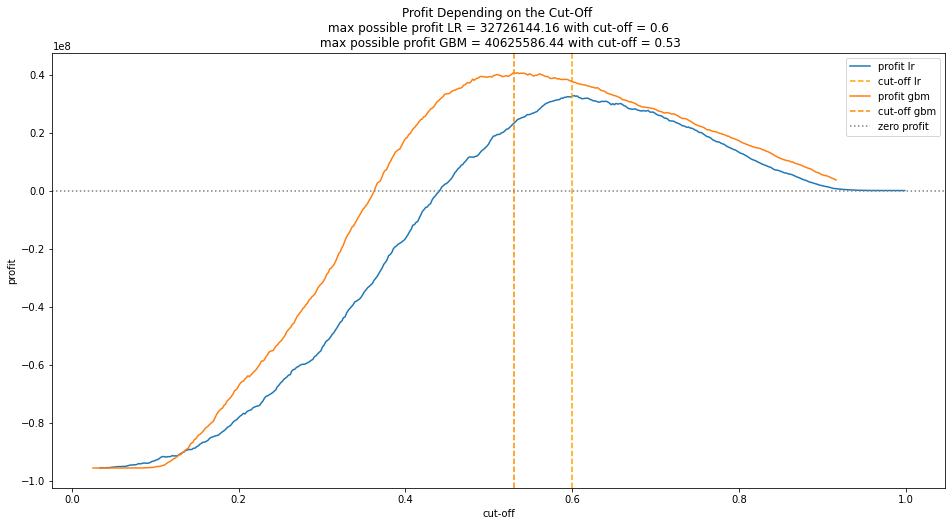

In [47]:
plt.figure(figsize=(16, 8))
plt.plot(np.linspace(np.min(y_preds_lr), np.max(y_preds_lr), 500), profits_lr, label='profit lr')
plt.axvline(np.round(np.linspace(np.min(y_preds_lr), np.max(y_preds_lr), 500)[np.argmax(profits_lr)], 2),
label='cut-off lr', linestyle='--', color='orange')

plt.plot(np.linspace(np.min(y_preds_gbm), np.max(y_preds_gbm), 500), profits_gbm, label='profit gbm')
plt.axvline(np.round(np.linspace(np.min(y_preds_gbm), np.max(y_preds_gbm), 500)[np.argmax(profits_gbm)], 2),
label='cut-off gbm', linestyle='--', color='darkorange')

plt.axhline(0, linestyle='dotted', color='grey', label='zero profit')
plt.xlabel('cut-off')
plt.ylabel('profit')


plt.title(f'Profit Depending on the Cut-Off \n max possible profit LR = {np.round(np.max(profits_lr), 2)} \
with cut-off = {a} \n max possible profit GBM = {np.round(np.max(profits_gbm), 2)} with cut-off = {b}')

plt.legend()
plt.show()

In [50]:
def bootstrap_with_y(X, y, preds, seed=None):
    pred = pd.DataFrame(preds)
    n = X.shape[0]
    y.index = range(n)
    X.index = range(n)
    pred.index = range(n) 
    np.random.seed(seed)
    idx = np.random.randint(0, n, n)
    return X.loc[idx], y.loc[idx], pred.loc[idx].values.reshape(-1)

In [51]:
def profit_cutoff(X_test, y_test, y_preds, max_iter=100):
    max_profits = []
    best_cut_offs = []

    for i in tqdm(range(max_iter)):
        X_bs, y_bs, preds_bs = bootstrap_with_y(X_test, y_test, y_preds)
        profits = []
        for cut_off in np.linspace(np.min(preds_bs), np.max(preds_bs), 100):
            profits.append(calc_profit(X_bs, y_bs, preds_bs, cut_off))
        max_profits.append(np.max(profits))
        best_cut_offs.append(np.linspace(np.min(preds_bs), np.max(preds_bs), 100)[np.argmax(profits)])
    return max_profits, best_cut_offs

def plot_profit_cutoff(max_profits, best_cut_offs, name):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_bs_hist(max_profits, 'Max Profit Distribution for {}'.format(name), 0, color='darkblue')
    plt.subplot(1, 2, 2)
    plot_bs_hist(best_cut_offs, 'Best Cut-Off Distribution for {}'.format(name), 0, color='darkorange')
    plt.show()

### Бустинг

In [52]:
max_profits_gbm, best_cut_offs_gbm = profit_cutoff(X_test, y_test, y_preds_gbm)

100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


In [53]:
def plot_norm_dist(dist, name, r=0, cl=None): 
    mean, sigma  = st.distributions.norm.fit(dist)
    x = np.linspace(np.min(dist), np.max(dist), 10000)
    fitted_data = st.distributions.norm.pdf(x, mean, sigma)
    plt.plot(x, fitted_data, label='Normal Distribution', linewidth=2)
    if cl: 
        ub = np.round(np.quantile(x, (1+cl)/2), 2)
        lb = np.round(np.quantile(x, (1-cl)/2), 2)
        plt.axvline(ub, label=f'{cl*100}% Confidence Interval', color='grey', linestyle='--')
        plt.axvline(lb, color='grey', linestyle='--')
        plt.title(f'Distribution of {name} \n mean={np.round(mean, 2)} \n lower bound={lb}, upper bound={ub}')
    plt.legend(loc='upper left')
    print(name)
    print('mean: {}'.format(np.round(mean, 2)))
    print([lb, ub])

Max Profit Distribution for LightGBM
mean: 40357760.02
[34511555.78, 46093094.38]
Best Cut-Off Distribution for LightGBM
mean: 0.54
[0.48, 0.59]


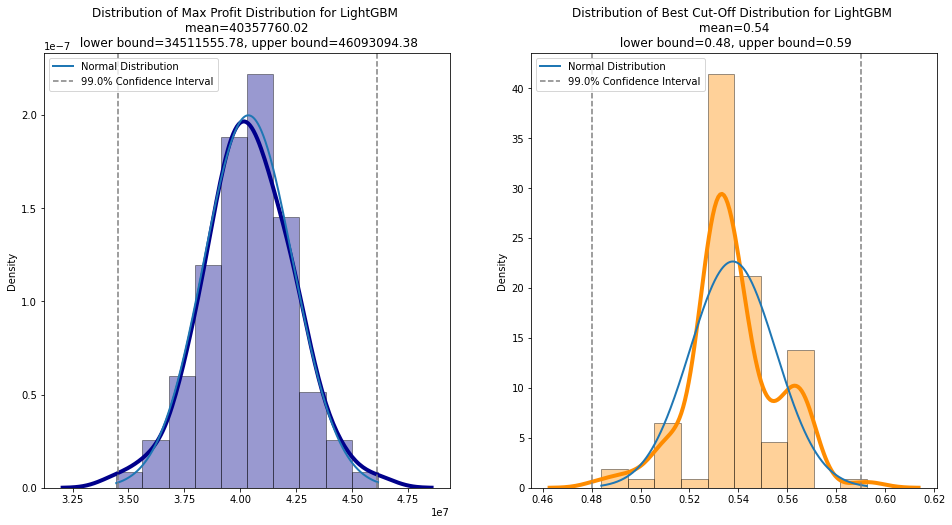

In [55]:
plot_profit_cutoff(max_profits_gbm, best_cut_offs_gbm, 'LightGBM')

### Логрег

In [56]:
max_profits_lr, best_cut_offs_lr = profit_cutoff(X_test_lr_2, y_test_lr, y_preds_lr)

100%|██████████| 100/100 [11:19<00:00,  6.80s/it]


Max Profit Distribution for LogReg
mean: 32485235.25
[27502822.09, 36819421.79]
Best Cut-Off Distribution for LogReg
mean: 0.6
[0.58, 0.62]


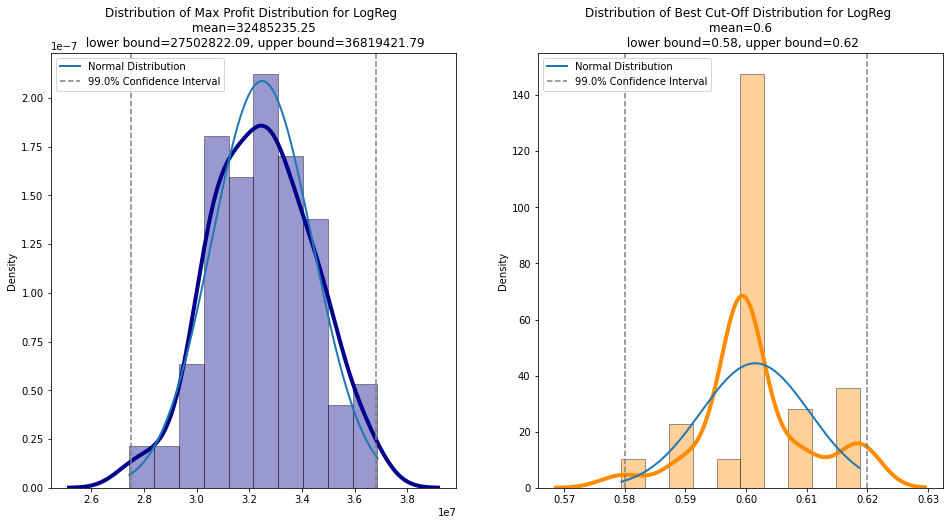

In [57]:
plot_profit_cutoff(max_profits_lr, best_cut_offs_lr, 'LogReg')